In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

# Load data and run some pre-processing steps:

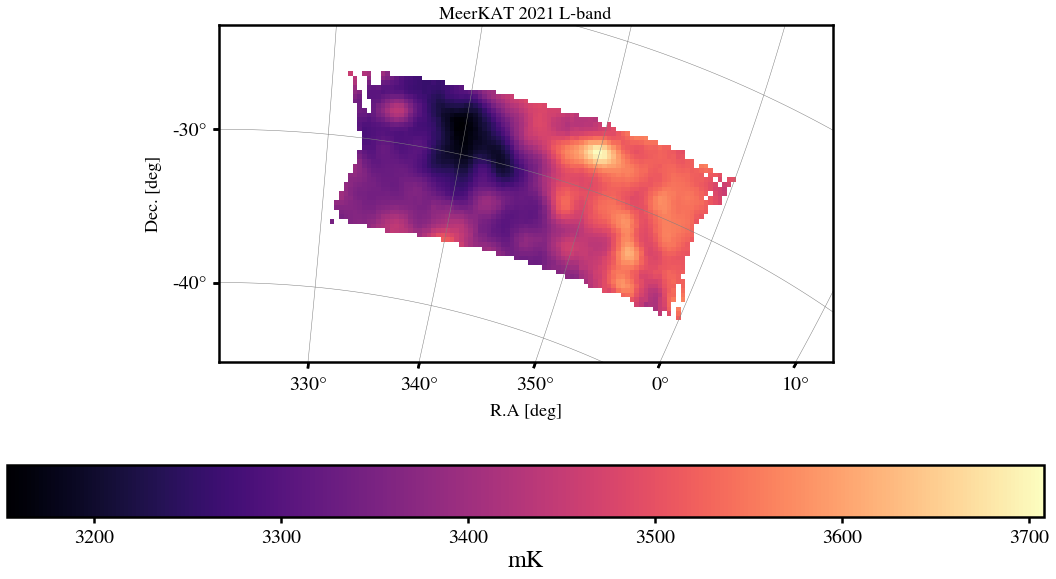

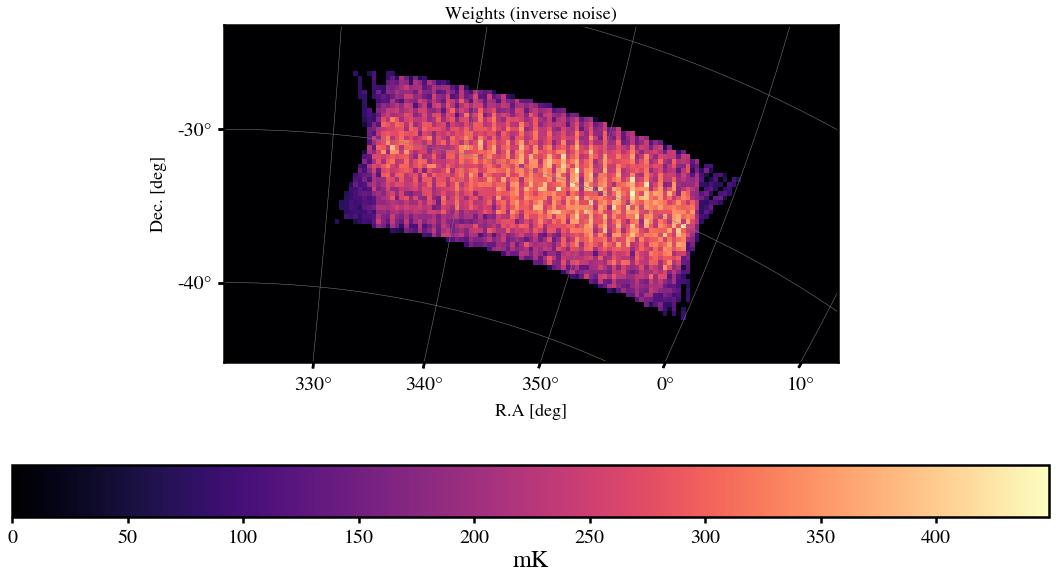

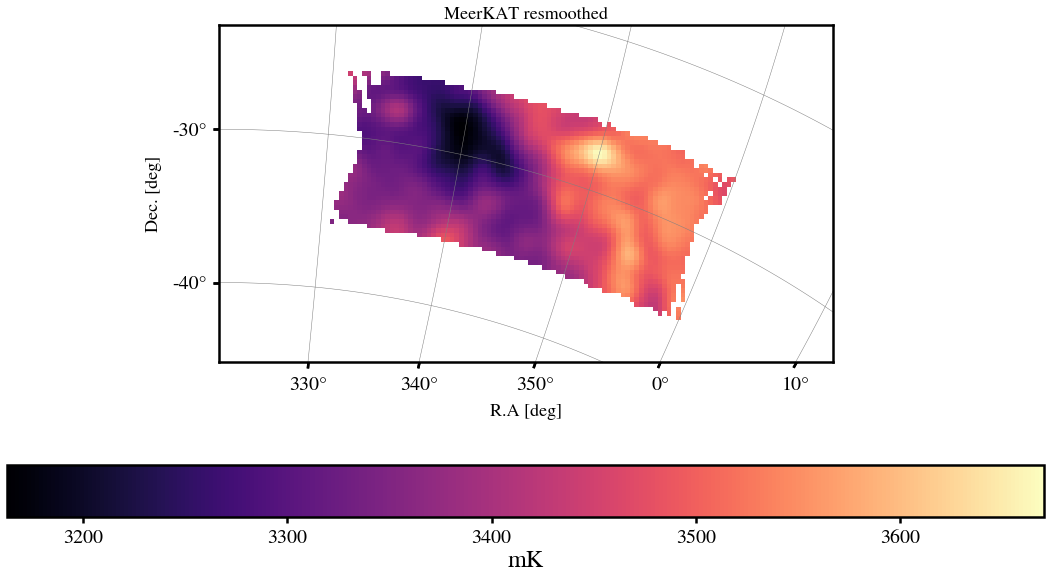

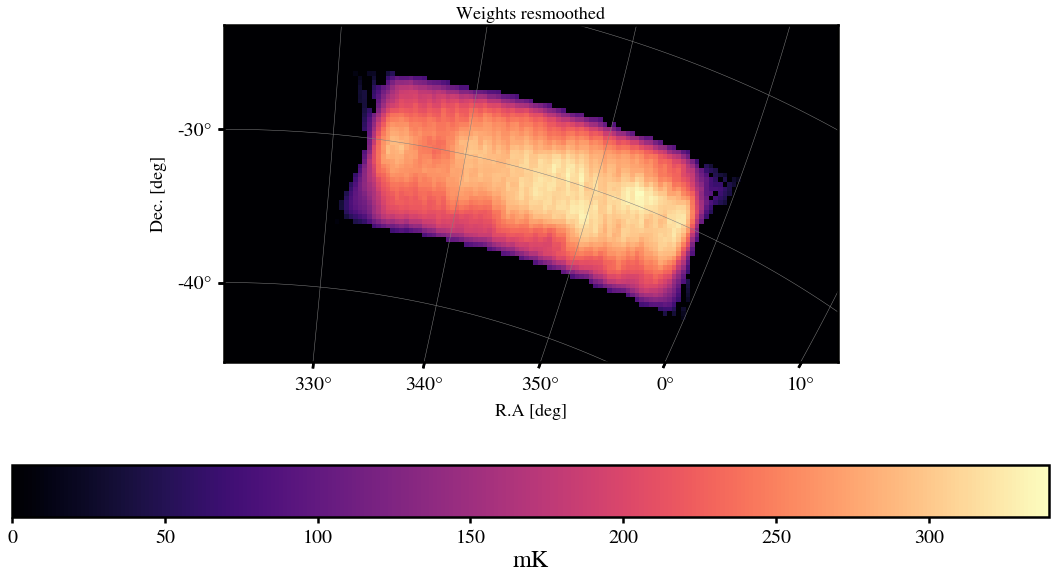

MeerKLASS trimmed sky area:  235.86457762801086


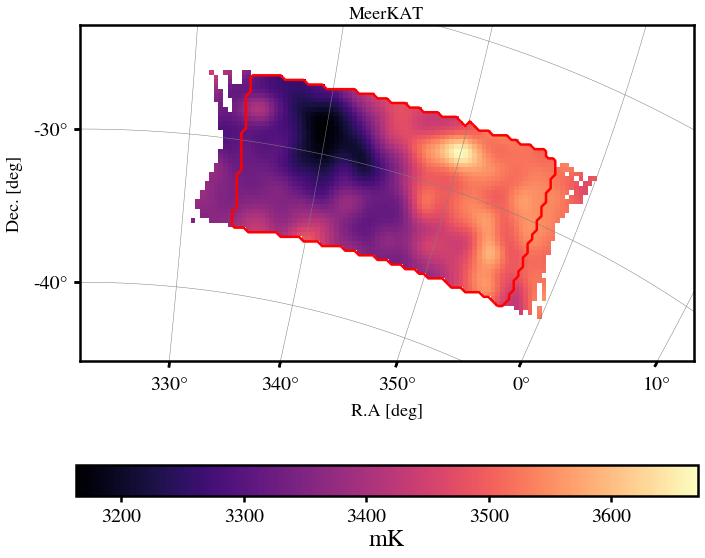

<Figure size 1296x648 with 0 Axes>

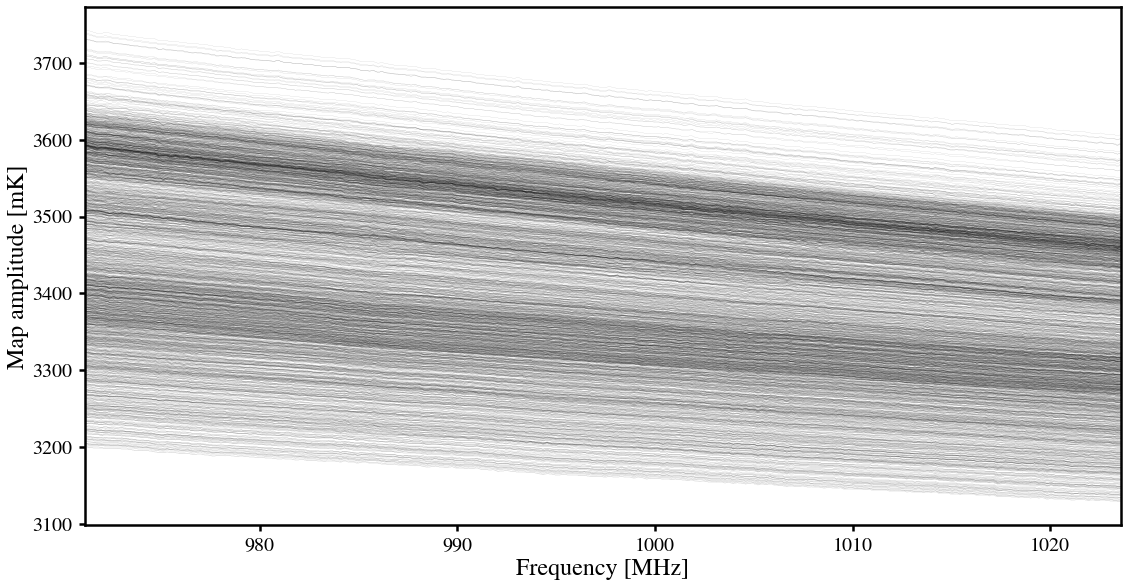

In [2]:
# Choose an L-band survey and read-in level6 MeerKAT data:
#survey = '2019'
survey = '2021'

#gal_cat = 'wigglez'
gal_cat = 'cmass'
if survey=='2021': gal_cat = 'gama'

doMock = False # Set True to load mock data for consistency checks

if survey=='2019':
    filestem = '/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p0.3d/p0.3d_sigma2.5_iter2/'
    map_file = filestem + 'Nscan366_Tsky_cube_p0.3d_sigma2.5_iter2.fits'
    numin,numax = 971,1023.2    
if survey=='2021':
    filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
    map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
    numin,numax = 971,1023.8 # default setting in Init.ReadIn()
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,numin=numin,numax=numax)
if doMock==True: 
    mockindx = np.random.randint(100)
    mockindx = 1
    MKmap_mock = np.load('/idia/projects/hi_im/meerpower/'+survey+'Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%mockindx)
nx,ny,nz = np.shape(MKmap)

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### IM weights (averaging of counts along LoS so not to increase rank of the map for FG cleaning):
w_HI = np.repeat(np.mean(counts_HI,2)[:, :, np.newaxis], nz, axis=2)

### Plot maps:
plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT ' + survey + ' L-band',ZeroCentre=False)
plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Weights (inverse noise)')
plt.show()

# Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
#from astropy.cosmology import Planck15 as cosmo_astropy
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift - defined as redshift of median frequency
zmin = (nu_21cm/np.max(nu)) - 1 # Minimum redshift of band
zmax = (nu_21cm/np.min(nu)) - 1 # Maximum redshift of band
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
r = 0.9 # cross-correlation coefficient
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing

### Map resmoothing:
MKmap_unsmoothed = np.copy(MKmap)
if gamma is not None:
    w_HI_orig = np.copy(w_HI)
    MKmap,w_HI = telescope.weighted_reconvolve(MKmap,w_HI_orig,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    if doMock==True: MKmap_mock,null = telescope.weighted_reconvolve(MKmap_mock,w_HI_orig,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
    plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Weights resmoothed')
plt.show()

### Trim map edges:
doTrim = True
if doTrim==True:
    if survey=='2019':
        #raminMK,ramaxMK = 152,173
        #decminMK,decmaxMK = -1,8
        raminMK,ramaxMK = 149,190
        decminMK,decmaxMK = -5,20
    
    if survey=='2021':
        raminMK,ramaxMK = 334,357
        #decminMK,decmaxMK = -35,-26.5
        decminMK,decmaxMK = np.min(dec[np.mean(W_HI,2)>0]),np.max(dec[np.mean(W_HI,2)>0])

    print('MeerKLASS trimmed sky area: ',str((ramaxMK-raminMK)*(decmaxMK-decminMK)))
    ### Before trimming map, show contour of trimmed area:
    MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
    plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
    MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

    if survey=='2019':
        cornercut_lim = 146 # set low to turn off
        cornercut = ra - dec < cornercut_lim
        MKmap[cornercut],w_HI[cornercut],W_HI[cornercut],counts_HI[cornercut] = 0,0,0,0

    contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='red')
    plt.show()

plot.LoSspectra(MKmap,W=W_HI,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

# Spectral analysis for possible frequency channel flagging:
Also remove some corners/extreme temp values

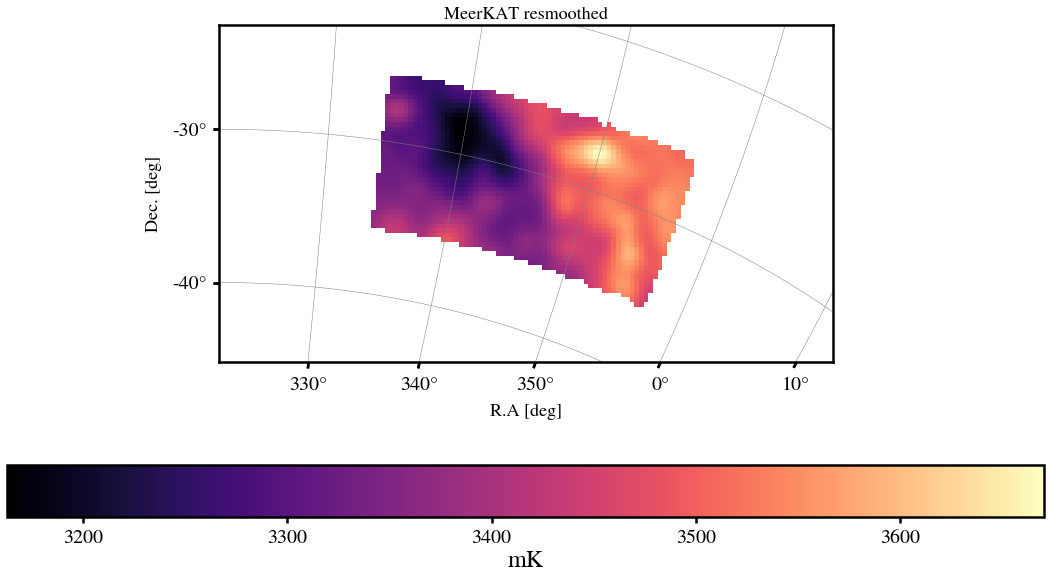

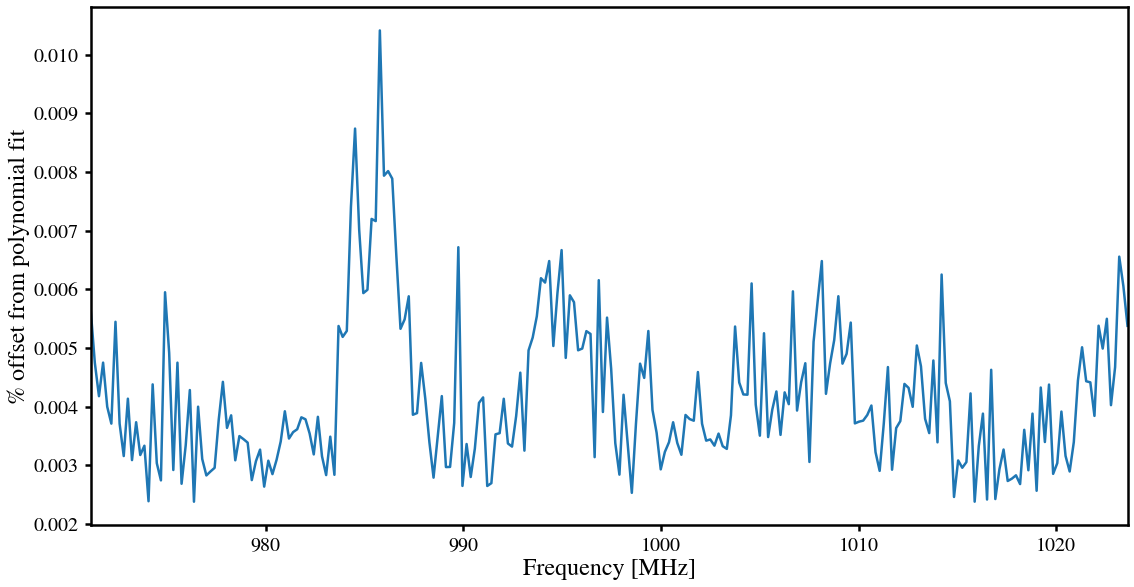

[]


<Figure size 1296x648 with 0 Axes>

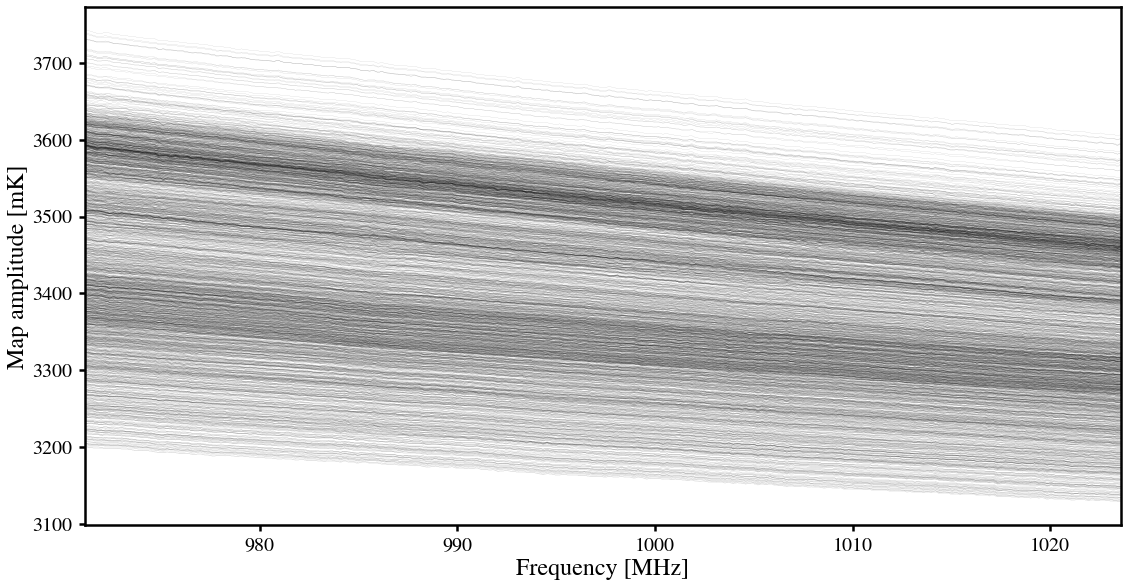

"\n### Analyse frequency variance to guide final flagging:\nvar = np.var(w_HI * MKmap,(0,1)) # variance in each frequnecy slice\npoly = model.FitPolynomial(nu,var,n=2)\noffsets = np.zeros(nz)\noffsets = np.abs(var - poly)\noffsetcut = 95e5 # Set to zero for no additional flagging\n#offsetcut = 0\nif offsetcut==0: flagindx = []\nelse: flagindx = np.where(offsets>offsetcut)[0]\nplt.plot(nu,var)\nplt.plot(nu,poly,color='black')\nplt.scatter(nu[flagindx],var[flagindx],color='red')\nplt.show()\nplt.axhline(offsetcut,color='red',ls='--')\nplt.plot(nu,offsets)\nplt.scatter(nu[flagindx],offsets[flagindx],color='red')\nplt.show()\nprint(flagindx)\n"

In [3]:
MKmap_flag,w_HI_flag,W_HI_flag = np.copy(MKmap),np.copy(w_HI),np.copy(W_HI)

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
if survey=='2019':
    extreme_temp_LoS = np.zeros(np.shape(ra))
    extreme_temp_LoS[MKmap[:,:,0]>3530] = 1
    extreme_temp_LoS[MKmap[:,:,0]<3100] = 1
    MKmap_flag[extreme_temp_LoS==1] = 0
    w_HI_flag[extreme_temp_LoS==1] = 0
    W_HI_flag[extreme_temp_LoS==1] = 0
    plot.Map(MKmap_flag,W=W_HI_flag,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
plt.show()

import model
nra,ndec = np.shape(ra)
offsets = np.zeros((nra,ndec,len(nu)))
for i in range(nra):
    for j in range(ndec):
        if W_HI_flag[i,j,0]==0: continue
        poly = model.FitPolynomial(nu,MKmap_flag[i,j,:],n=2)
        offsets[i,j,:] = np.abs((MKmap_flag[i,j,:] - poly)/MKmap_flag[i,j,:])
offsets = 100*np.mean(offsets,axis=(0,1))

if survey=='2019': offsetcut = 0.029 # Set to zero for no additional flagging
#if survey=='2019': offsetcut = None # Set to None for no additional flagging
if survey=='2021': offsetcut = None
plt.plot(nu,offsets)
if offsetcut is not None: plt.axhline(offsetcut,color='red')
plt.xlabel('Frequency [MHz]')
plt.ylabel('% offset from polynomial fit')
plt.xlim(nu[0],nu[-1])
plt.show()

if offsetcut is None: flagindx = []
else: flagindx = np.where(offsets>offsetcut)[0]

flags = np.full(nz,False)
flags[flagindx] = True

MKmap_flag[:,:,flags] = 0
w_HI_flag[:,:,flags] = 0 
W_HI_flag[:,:,flags] = 0

print(flagindx)

plot.LoSspectra(MKmap_flag,W=W_HI_flag,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
'''
plt.axvline(nu[87],color='red',alpha=0.2)
plt.axvline(nu[108],color='red',alpha=0.2)
plt.axvline(nu[112],color='red',alpha=0.2)
plt.axvline(nu[124],color='red',alpha=0.2)
plt.axvline(nu[127],color='red',alpha=0.2)
plt.axvline(nu[135],color='red',alpha=0.2)
plt.axvline(nu[165],color='red',alpha=0.2)
plt.axvline(nu[212],color='red',alpha=0.2)
plt.axvline(nu[236],color='red',alpha=0.2)
'''
plt.show()
'''
# Further manual flagging?:
flags[np.array([87,108,112,124,127,135,165,212,236])] = True
MKmap_flag[:,:,flags] = 0
w_HI_flag[:,:,flags] = 0 
W_HI_flag[:,:,flags] = 0
plot.LoSspectra(MKmap_flag,W=W_HI_flag,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()
'''

'''
### Analyse frequency variance to guide final flagging:
var = np.var(w_HI * MKmap,(0,1)) # variance in each frequnecy slice
poly = model.FitPolynomial(nu,var,n=2)
offsets = np.zeros(nz)
offsets = np.abs(var - poly)
offsetcut = 95e5 # Set to zero for no additional flagging
#offsetcut = 0
if offsetcut==0: flagindx = []
else: flagindx = np.where(offsets>offsetcut)[0]
plt.plot(nu,var)
plt.plot(nu,poly,color='black')
plt.scatter(nu[flagindx],var[flagindx],color='red')
plt.show()
plt.axhline(offsetcut,color='red',ls='--')
plt.plot(nu,offsets)
plt.scatter(nu[flagindx],offsets[flagindx],color='red')
plt.show()
print(flagindx)
'''

# Principal component analysis:

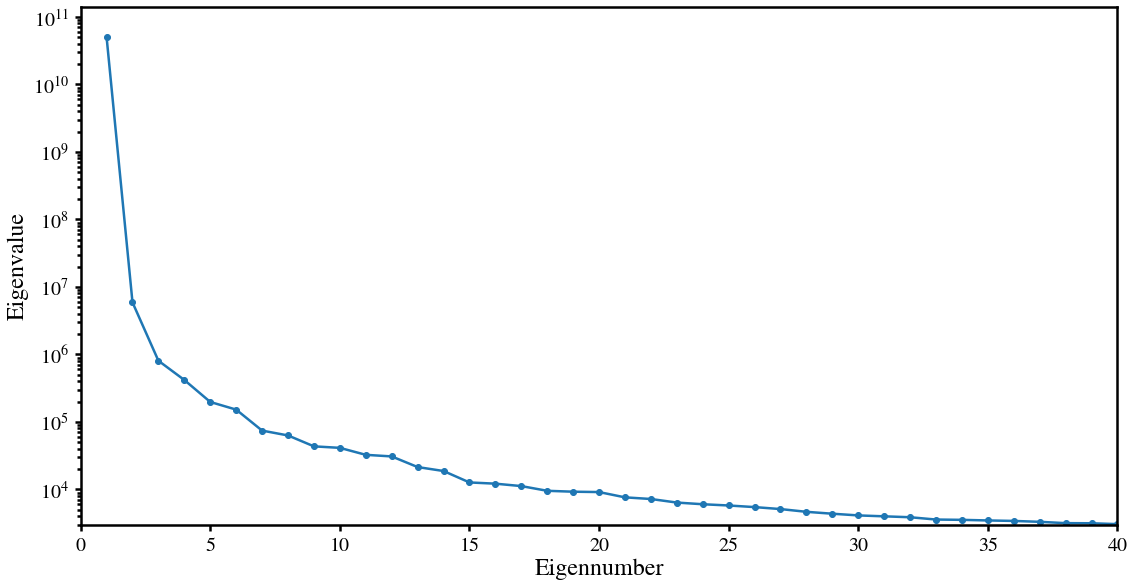

<Figure size 1296x648 with 0 Axes>

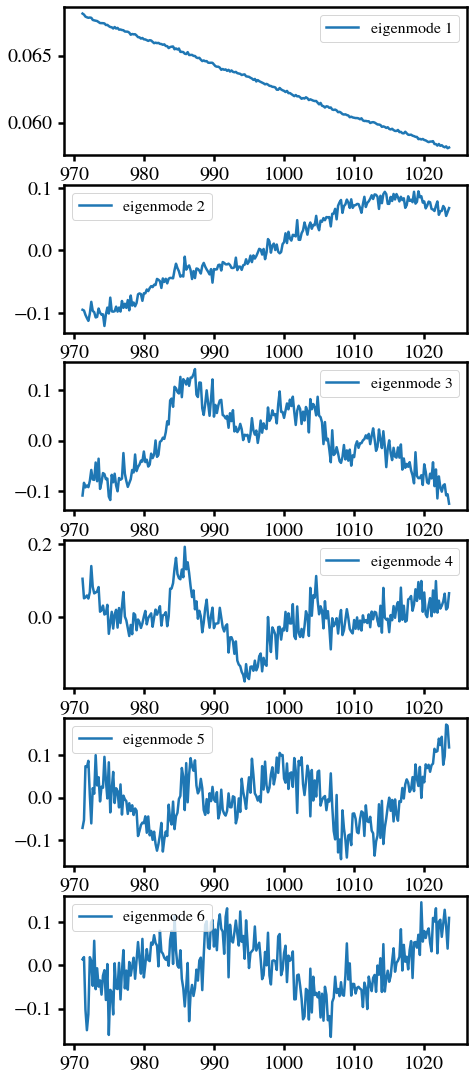

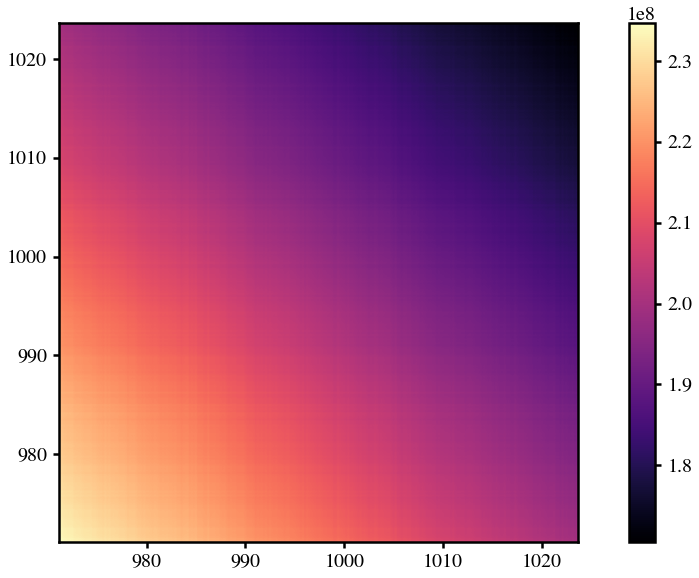

In [4]:
import foreground # PCA clean and transfer function calculations performed here
import model

if doMock==False:
    ### Analyse frequency covariance and PCA modes to guide flagging and foreground cleaning choices:
    C,eignumb,eigenval,V = foreground.PCAclean(MKmap_flag,N_fg=1,W=W_HI_flag,w=w_HI_flag,returnAnalysis=True,MeanCentre=True) # weights included in covariance calculation
    plot.EigenSpectrum(eignumb,eigenval)
    plt.figure()
    Num = 6
    chart = 100*Num + 11
    plt.figure(figsize=(7,3*Num))
    for i in range(Num):
        plt.subplot(chart + i)
        plt.plot(nu[~flags],V[:,i][~flags],label='eigenmode %s'%(i+1))
        #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
        plt.legend(fontsize=16)
    plt.figure()
    Cplot = np.copy(C)
    Cplot[Cplot==0] = np.nan
    plt.imshow(Cplot,extent=[nu[0],nu[-1],nu[0],nu[-1]])
    plt.colorbar()
    plt.show()

# Foreground clean:

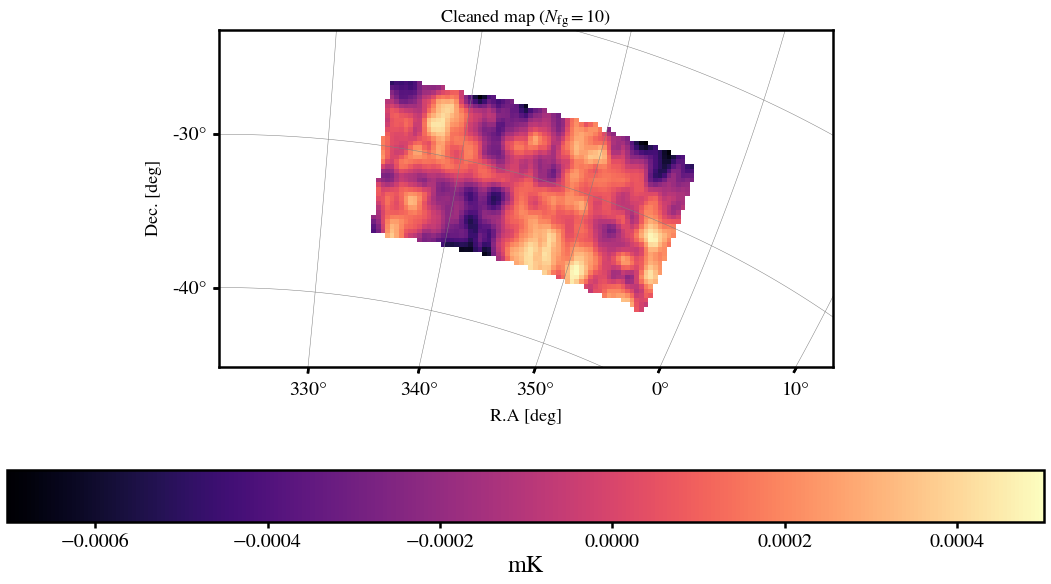

In [5]:
if survey is '2019': N_fg = 12
if survey is '2021': N_fg = 10
MKmap,w_HI,W_HI = np.copy(MKmap_flag),np.copy(w_HI_flag),np.copy(W_HI_flag) # Propagate flagged maps for rest of analysis

if doMock==False:
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
if doMock==True:
    MKmap_mock[W_HI==0] = 0 # apply same flags, trims, cuts as data
    #MKmap_clean = MKmap_mock
    MKmap_clean = foreground.PCAclean(MKmap + MKmap_mock ,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation

plot.Map(MKmap_clean,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title=r'Cleaned map ($N_{\rm fg}=%s$)'%N_fg,ZeroCentre=False)
plt.show()

W_HI_untrim,w_HI_untrim = np.copy(W_HI),np.copy(w_HI)
if gal_cat=='wigglez': # obtained from min/max of wigglez catalogue    
    ramin_gal,ramax_gal = 152.906631, 172.099625
    decmin_gal,decmax_gal = -1.527391, 8.094599
if gal_cat=='gama':
    ramin_gal,ramax_gal = 339,351
    decmin_gal,decmax_gal = -35,-30
'''
if gal_cat=='wigglez' or gal_cat=='gama':
    MKmap_clean,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap_clean,w_HI,W_HI,counts_HI,ramin=ramin_gal,ramax=ramax_gal,decmin=decmin_gal,decmax=decmax_gal)
    plot.Map(MKmap_clean,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title=r'Cleaned map, trimmed to galaxy footprint ($N_{\rm fg}=%s$)'%N_fg,ZeroCentre=False)
    plt.show()
'''
if gal_cat=='wigglez':
    MKmap_clean,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap_clean,w_HI,W_HI,counts_HI,ramin=ramin_gal,ramax=ramax_gal,decmin=decmin_gal,decmax=decmax_gal)
    #w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,w_HI,W_HI,counts_HI,ramin=ramin_gal,ramax=ramax_gal,decmin=decmin_gal,decmax=decmax_gal)
    plot.Map(MKmap_clean,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title=r'Cleaned map, trimmed to galaxy footprint ($N_{\rm fg}=%s$)'%N_fg,ZeroCentre=False)
    plt.show()

if gal_cat=='gama': 
    w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,w_HI,W_HI,counts_HI,ramin=ramin_gal,ramax=ramax_gal,decmin=decmin_gal,decmax=decmax_gal)
    # Re-do clean with trimmed mask:
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation


# Read-in overlapping galaxy survey:

Number of overlapping  gama  galaxies:  2269


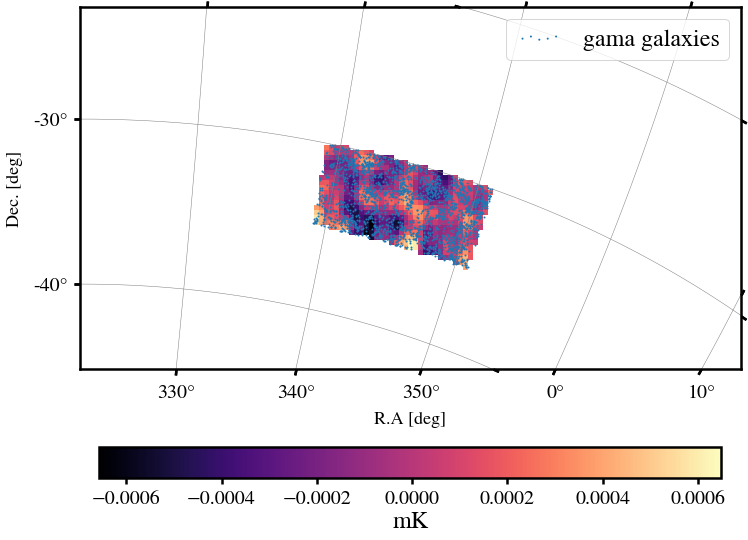

In [6]:
from astropy.io import fits
if survey=='2019':
    if gal_cat=='wigglez':
        if doMock==False: # Read-in WiggleZ galaxies (provided by Laura):
            galcat = np.genfromtxt('/users/scunnington/MeerKAT/LauraShare/wigglez_reg11hrS_z0pt30_0pt50/reg11data.dat', skip_header=1)
            ra_g,dec_g,z_g = galcat[:,0],galcat[:,1],galcat[:,2]
        if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat_%s.npy'%mockindx)
        z_Lband = (z_g>zmin) & (z_g<zmax) # Cut redshift to MeerKAT IM range:
        ra_g,dec_g,z_g = ra_g[z_Lband],dec_g[z_Lband],z_g[z_Lband]
    if gal_cat=='cmass':
        if doMock==False: # Read-in BOSS-CMASS galaxies (in Yi-Chao's ilifu folder - also publically available from: https://data.sdss.org/sas/dr12/boss/lss):
            filename = '/idia/users/ycli/SDSS/dr12/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz'
            hdu = fits.open(filename)
            ra_g,dec_g,z_g = hdu[1].data['RA'],hdu[1].data['DEC'],hdu[1].data['Z']
        if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat_%s.npy'%mockindx)
        ra_g,dec_g,z_g = Init.pre_process_2019Lband_CMASS_galaxies(ra_g,dec_g,z_g,ra,dec,zmin,zmax,W_HI)
        
if survey=='2021':
    if doMock==False: # Read-in GAMA galaxies: (obtained from GAMA DR4: https://www.gama-survey.org/dr4/data/cat/G23InputCat/v11/)
        Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
        hdu = fits.open(Fits)
        ra_g,dec_g,z_g = hdu[1].data['RA'],hdu[1].data['DEC'],hdu[1].data['Z']
    if doMock==True: ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%mockindx)
    # Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
    GAMAcutmask = (ra_g>ramin_gal) & (ra_g<ramax_gal) & (dec_g>decmin_gal) & (dec_g<decmax_gal) & (z_g>zmin) & (z_g<zmax)
    ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]

print('Number of overlapping ', gal_cat,' galaxies: ', str(len(ra_g)))

### Plot MK map with overlaid galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap_clean,2)
img[np.sum(W_HI,2)==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label=gal_cat+' galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

# Assign galaxy bias:
if gal_cat=='wigglez': b_g = np.sqrt(0.83) # for WiggleZ at z_eff=0.41 - from https://arxiv.org/pdf/1104.2948.pdf [pg.9 rhs second quantity]
if gal_cat=='cmass':b_g = 1.85 # Mentioned in https://arxiv.org/pdf/1607.03155.pdf
if gal_cat=='gama': b_g = 2.35 # tuned by eye in GAMA auto-corr

# Gridding maps and galaxies to Cartesian field:

In [7]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
window = 'ngp'
compensate = True
interlace = False
nxmap,nymap,nzmap = np.shape(MKmap)
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
nzcell2vox = int(nzmap/cell2vox_factor)
if nzcell2vox % 2 != 0: nzcell2vox += 1 # Ensure z-dimension is even for FFT purposes
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),nzcell2vox
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI_untrim,dobuffer=True) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

print(lx,ly,lz)
print(nx_rg,ny_rg,nz_rg)

# Regrid cleaned map, IM mask and weights to Cartesian field:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=W_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
W_HI_rg,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)[0]

# Grid galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]

# Construct galaxy selection function:
if survey=='2019': 
    if gal_cat=='wigglez': # grid WiggleZ randoms straight to Cartesian field for survey selection:
        BuildSelFunc = False
        if BuildSelFunc==True:
            nrand = 1000 # number of WiggleZ random catalogues to use in selection function (max is 1000)
            W_g_rg = np.zeros(np.shape(n_g_rg))
            for i in range(1,nrand):
                plot.ProgressBar(i,nrand)
                galcat = np.genfromtxt( '/users/scunnington/MeerKAT/LauraShare/wigglez_reg11hrS_z0pt30_0pt50/reg11rand%s.dat' %'{:04d}'.format(i), skip_header=1)
                ra_g_rand,dec_g_rand,z_g_rand = galcat[:,0],galcat[:,1],galcat[:,2]
                z_Lband = (z_g_rand>zmin) & (z_g_rand<zmax) # Cut redshift to MeerKAT IM range:
                ra_g_rand,dec_g_rand,z_g_rand = ra_g_rand[z_Lband],dec_g_rand[z_Lband],z_g_rand[z_Lband]
                xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_rand,dec_g_rand,z_g_rand,ramean_arr=ra,decmean_arr=dec,doTile=False)
                W_g_rg += grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)[0]
            W_g_rg /= nrand
            np.save('/idia/projects/hi_im/meerpower/2019Lband/wigglez/data/wiggleZ_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor,W_g_rg)
        W_g_rg = np.load('/idia/projects/hi_im/meerpower/2019Lband/wigglez/data/wiggleZ_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor)
    
    if gal_cat=='cmass':
    # Data obtained from untarrting DR12 file at: https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-DR12NGC-COMPSAM_V6C.tar.gz
        BuildSelFunc = False
        if BuildSelFunc==True:
            nrand = 2048 # number of WiggleZ random catalogues to use in selection function (max is 1000)
            W_g_rg = np.zeros(np.shape(n_g_rg))
            for i in range(1,nrand):
                plot.ProgressBar(i,nrand)
                galcat = np.genfromtxt( '/idia/projects/hi_im/meerpower/2019Lband/cmass/sdss/Patchy-Mocks-DR12NGC-COMPSAM_V6C_%s.dat' %'{:04d}'.format(i+1), skip_header=1)
                ra_g_rand,dec_g_rand,z_g_rand = galcat[:,0],galcat[:,1],galcat[:,2]
                ra_g_rand,dec_g_rand,z_g_rand = Init.pre_process_2019Lband_CMASS_galaxies(ra_g_rand,dec_g_rand,z_g_rand,ra,dec,zmin,zmax,W_HI)
                xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_rand,dec_g_rand,z_g_rand,ramean_arr=ra,decmean_arr=dec,doTile=False)
                W_g_rg += grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)[0]
            W_g_rg /= nrand
            np.save('/idia/projects/hi_im/meerpower/2019Lband/cmass/data/cmass_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor,W_g_rg)
        W_g_rg = np.load('/idia/projects/hi_im/meerpower/2019Lband/cmass/data/cmass_stackedrandoms_cell2voxfactor=%s.npy'%cell2vox_factor)

if survey=='2021': # grid uncut pixels to obtain binary mask in comoving space in absence of GAMA mocks for survey selection:
    ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
    '''
    if doTrim==True:
        MKcutmask = (ra_p>ramin_gal) & (ra_p<ramax_gal) & (dec_p>decmin_gal) & (dec_p<decmax_gal)        
        xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
        null,W_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
    '''
    GAMAcutmask = (ra_p>ramin_gal) & (ra_p<ramax_gal) & (dec_p>decmin_gal) & (dec_p<decmax_gal)        
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
    null,W_g_rg,null = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
        
# Calculate FKP weigts:
'''
W_g01_rg = np.ones(np.shape(W_g_rg)) # Binary window function for galaxies to mark dead pixels
W_g01_rg[W_g_rg==0] = 0
W_g_rg = W_g_rg/np.sum(W_g_rg) # normalised window function for FKP weight calculation
P0 = 5000 # at k~0.1
nbar = np.sum(n_g_rg)/(lx*ly*lz) # Calculate number density inside survey footprint
w_g_rg = 1/(1 + W_g_rg*(nx*ny*nz)*nbar*P0)
w_g_rg[W_g01_rg==0] = 0 # zero weight for dead pixels
'''
#w_g_rg = np.ones(np.shape(W_g_rg))
w_g_rg = np.copy(W_g_rg)

### For calculating the GAMA number density:
'''
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=False,interlace=False,verbose=False)
V_frac = np.sum(W_g_rg)/(nx_rg*ny_rg*nz_rg)
print(np.min(W_g_rg),np.max(W_g_rg))
print(V_frac)
print( np.sum(n_g_rg) / (lx*ly*lz * V_frac) )
print( np.sum(n_g_rg) / (lx*ly*lz * V_frac) * 1e4)
'''

MKmap_clean_rg_notaper,w_HI_rg_notaper,W_HI_rg_notaper = np.copy(MKmap_clean_rg),np.copy(w_HI_rg),np.copy(W_HI_rg)
n_g_rg_notaper,w_g_rg_notaper,W_g_rg_notaper = np.copy(n_g_rg),np.copy(w_g_rg),np.copy(W_g_rg)

632.1863698362115 341.4686358529778 231.45516388047656
88 48 168


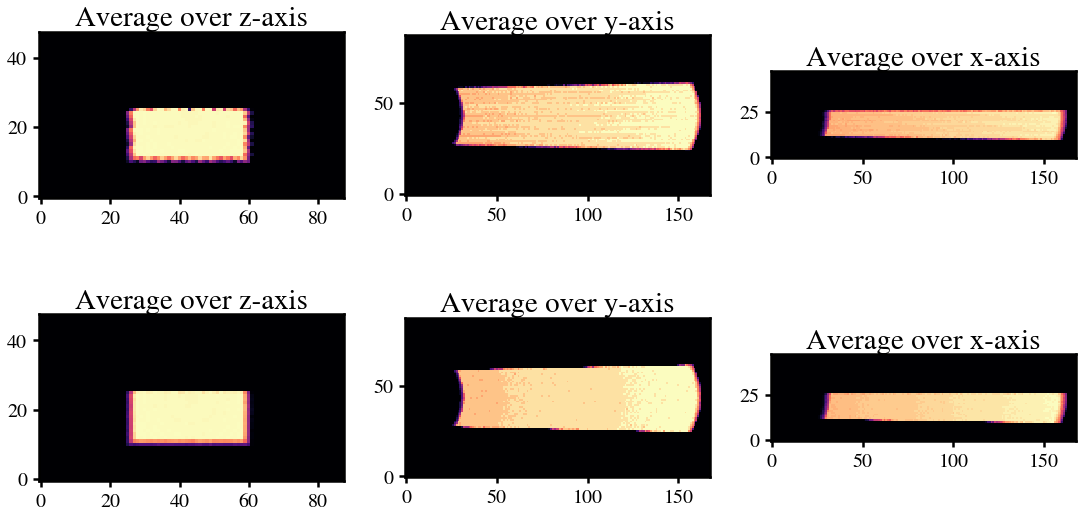

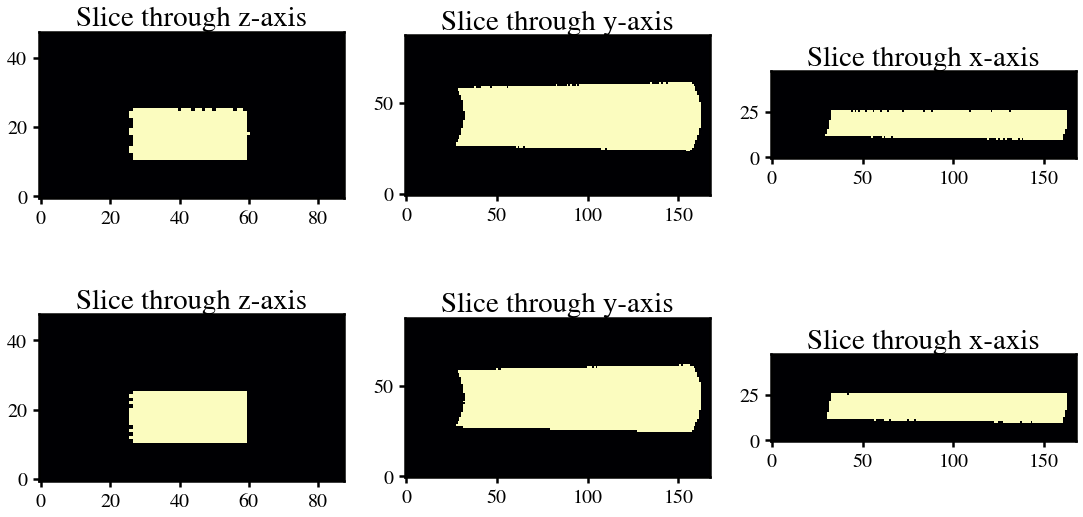

In [8]:
### Gridding sanity-check averages and looping GIFs to check footprints are well sampled (minimal holes):
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(np.mean(W_HI_rg_notaper,2).T,interpolation='none')
axs[0,0].set_title('Average over z-axis')
axs[0,1].imshow(np.mean(W_HI_rg_notaper,1),interpolation='none')
axs[0,1].set_title('Average over y-axis')
axs[0,2].imshow(np.mean(W_HI_rg_notaper,0),interpolation='none')
axs[0,2].set_title('Average over x-axis')
axs[1,0].imshow(np.mean(W_g_rg_notaper,2).T,interpolation='none')
axs[1,0].set_title('Average over z-axis')
axs[1,1].imshow(np.mean(W_g_rg_notaper,1),interpolation='none')
axs[1,1].set_title('Average over y-axis')
axs[1,2].imshow(np.mean(W_g_rg_notaper,0),interpolation='none')
axs[1,2].set_title('Average over x-axis')
plt.show()

fig, axs = plt.subplots(2,3)
axs[0,0].imshow(W_HI_rg_notaper[:,:,int(nz_rg/2)].T,interpolation='none')
axs[0,0].set_title('Slice through z-axis')
axs[0,1].imshow(W_HI_rg_notaper[:,int(ny_rg/2),:],interpolation='none')
axs[0,1].set_title('Slice through y-axis')
axs[0,2].imshow(W_HI_rg_notaper[int(nx_rg/2),:,:],interpolation='none')
axs[0,2].set_title('Slice through x-axis')
axs[1,0].imshow(W_g_rg_notaper[:,:,int(nz_rg/2)].T,interpolation='none')
axs[1,0].set_title('Slice through z-axis')
axs[1,1].imshow(W_g_rg_notaper[:,int(ny_rg/2),:],interpolation='none')
axs[1,1].set_title('Slice through y-axis')
axs[1,2].imshow(W_g_rg_notaper[int(nx_rg/2),:,:],interpolation='none')
axs[1,2].set_title('Slice through x-axis')
plt.show()

In [9]:
### Gridding sanity-check (2) averages and looping GIFs to check footprints are well sampled (minimal holes):
'''
from IPython.display import clear_output
import collections
%matplotlib inline
ix,iy,iz = 0,0,0
for i in range(np.max(ndim_rg)):
    clear_output(wait=True)
    fig, axs = plt.subplots(2,3)
    axs[0,0].set_title('Looping over z-axis')
    axs[0,0].imshow(W_HI_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=1)
    axs[0,0].text(1,1,'iz=%s'%iz,color='yellow')
    axs[0,1].set_title('Looping over y-axis')
    axs[0,1].imshow(W_HI_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=1)
    axs[0,1].text(1,1,'iy=%s'%iy,color='yellow')
    axs[0,2].set_title('Looping over x-axis')
    axs[0,2].imshow(W_HI_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=1)
    axs[0,2].text(1,1,'ix=%s'%ix,color='yellow')
    axs[1,0].set_title('Looping over z-axis')
    axs[1,0].imshow(W_g_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,0].text(1,1,'iz=%s'%iz,color='yellow')
    axs[1,1].set_title('Looping over y-axis')
    axs[1,1].imshow(W_g_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,1].text(1,1,'iy=%s'%iy,color='yellow')
    axs[1,2].set_title('Looping over x-axis')
    axs[1,2].imshow(W_g_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=np.max(W_g_rg))
    axs[1,2].text(1,1,'ix=%s'%ix,color='yellow')
    plt.show();
    if i<(nx_rg-1): ix += 1
    if i<(ny_rg-1): iy += 1
    if i<(nz_rg-1): iz += 1
'''

"\nfrom IPython.display import clear_output\nimport collections\n%matplotlib inline\nix,iy,iz = 0,0,0\nfor i in range(np.max(ndim_rg)):\n    clear_output(wait=True)\n    fig, axs = plt.subplots(2,3)\n    axs[0,0].set_title('Looping over z-axis')\n    axs[0,0].imshow(W_HI_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=1)\n    axs[0,0].text(1,1,'iz=%s'%iz,color='yellow')\n    axs[0,1].set_title('Looping over y-axis')\n    axs[0,1].imshow(W_HI_rg_notaper[:,iy,:],interpolation='none',vmin=0,vmax=1)\n    axs[0,1].text(1,1,'iy=%s'%iy,color='yellow')\n    axs[0,2].set_title('Looping over x-axis')\n    axs[0,2].imshow(W_HI_rg_notaper[ix,:,:],interpolation='none',vmin=0,vmax=1)\n    axs[0,2].text(1,1,'ix=%s'%ix,color='yellow')\n    axs[1,0].set_title('Looping over z-axis')\n    axs[1,0].imshow(W_g_rg_notaper[:,:,iz].T,interpolation='none',vmin=0,vmax=np.max(W_g_rg))\n    axs[1,0].text(1,1,'iz=%s'%iz,color='yellow')\n    axs[1,1].set_title('Looping over y-axis')\n    axs[1,1].imshow(W_g_r

# Footprint tapering/apodisation:

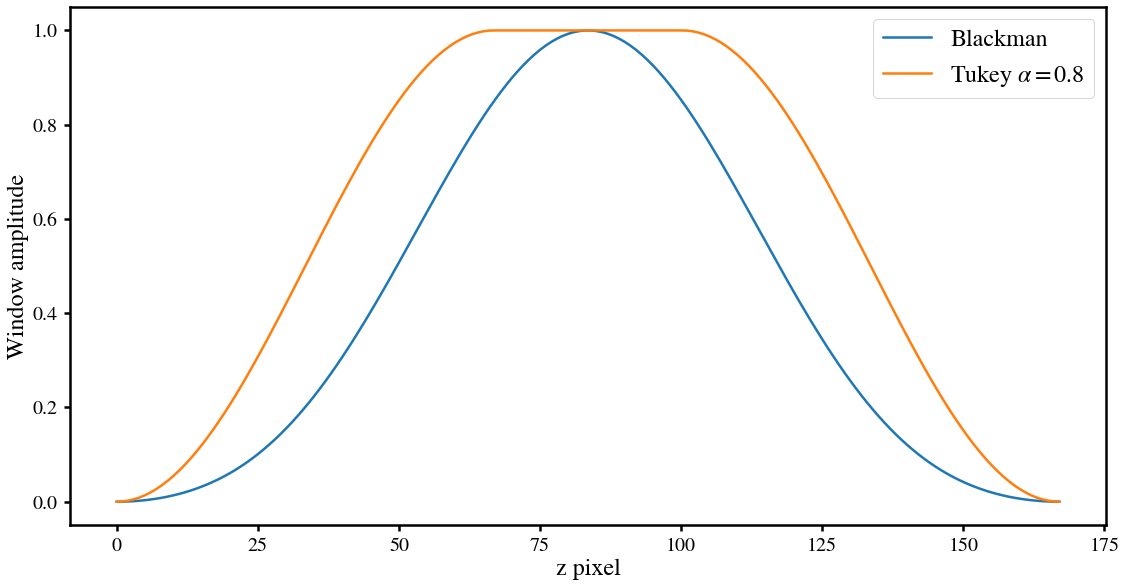

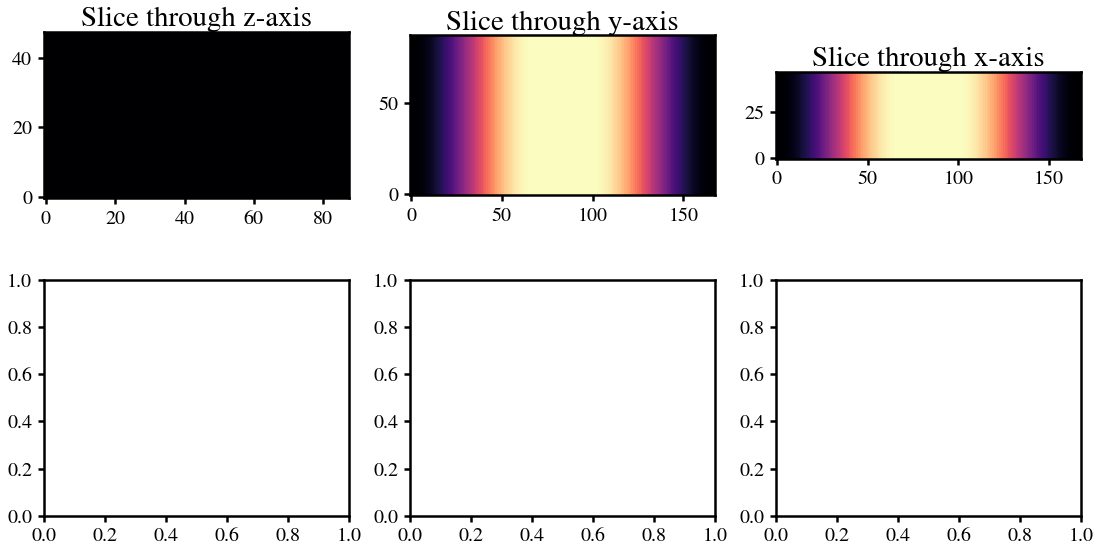

In [10]:
from scipy import signal

### Choose no taper:
#taper_HI,taper_g = 1,1

### Choose to use Blackman window function along z direction as taper:
blackman = np.reshape( np.tile(np.blackman(nz_rg), (nx_rg,ny_rg)) , (nx_rg,ny_rg,nz_rg) ) # Blackman function along every LoS

tukey_alpha = 0.8
tukey = np.reshape( np.tile(signal.windows.tukey(nz_rg, alpha=tukey_alpha), (nx_rg,ny_rg)) , (nx_rg,ny_rg,nz_rg) ) # Blackman function along every LoS

#taper_HI = blackman
#taper_g = blackman
taper_HI = tukey
#taper_g = tukey
#taper_HI = 1
taper_g = 1

plt.plot(blackman[0,0,:],label='Blackman')
plt.plot(tukey[0,0,:],label=r'Tukey $\alpha=%s$'%tukey_alpha)
plt.xlabel('z pixel')
plt.ylabel('Window amplitude')
plt.legend()
plt.show()

### Choose to implement a Gaussian footprint edge smoothing window functions:
'''
if survey=='2019': 
    taper_HI = grid.GaussianFootprintTaper(W_HI_rg)
    taper_g = 1
if survey=='2021': taper_HI,taper_g = grid.GaussianFootprintTaper(W_HI_rg,W_g_rg)
'''

# Multiply tapering windows by all fields that undergo Fourier transforms:
#MKmap_clean_rg = taper_HI*MKmap_clean_rg_notaper
#n_g_rg = taper_g*n_g_rg_notaper
w_HI_rg = taper_HI*w_HI_rg_notaper
w_g_rg = taper_g*w_g_rg_notaper
#W_HI_rg = taper_HI*W_HI_rg_notaper
#W_g_rg = taper_g*W_g_rg_notaper

fig, axs = plt.subplots(2,3)
if taper_HI is not 1:
    axs[0,0].imshow(taper_HI[:,:,int(nz_rg/2)].T,interpolation='none')
    axs[0,0].set_title('Slice through z-axis')
    axs[0,1].imshow(taper_HI[:,int(ny_rg/2),:],interpolation='none')
    axs[0,1].set_title('Slice through y-axis')
    axs[0,2].imshow(taper_HI[int(nx_rg/2),:,:],interpolation='none')
    axs[0,2].set_title('Slice through x-axis')
if taper_g is not 1:
    axs[1,0].imshow(taper_g[:,:,int(nz_rg/2)].T,interpolation='none')
    axs[1,0].set_title('Slice through z-axis')
    axs[1,1].imshow(taper_g[:,int(ny_rg/2),:],interpolation='none')
    axs[1,1].set_title('Slice through y-axis')
    axs[1,2].imshow(taper_g[int(nx_rg/2),:,:],interpolation='none')
    axs[1,2].set_title('Slice through x-axis')
plt.show()

# Power spectrum measurement and modelling (without signal loss correction):

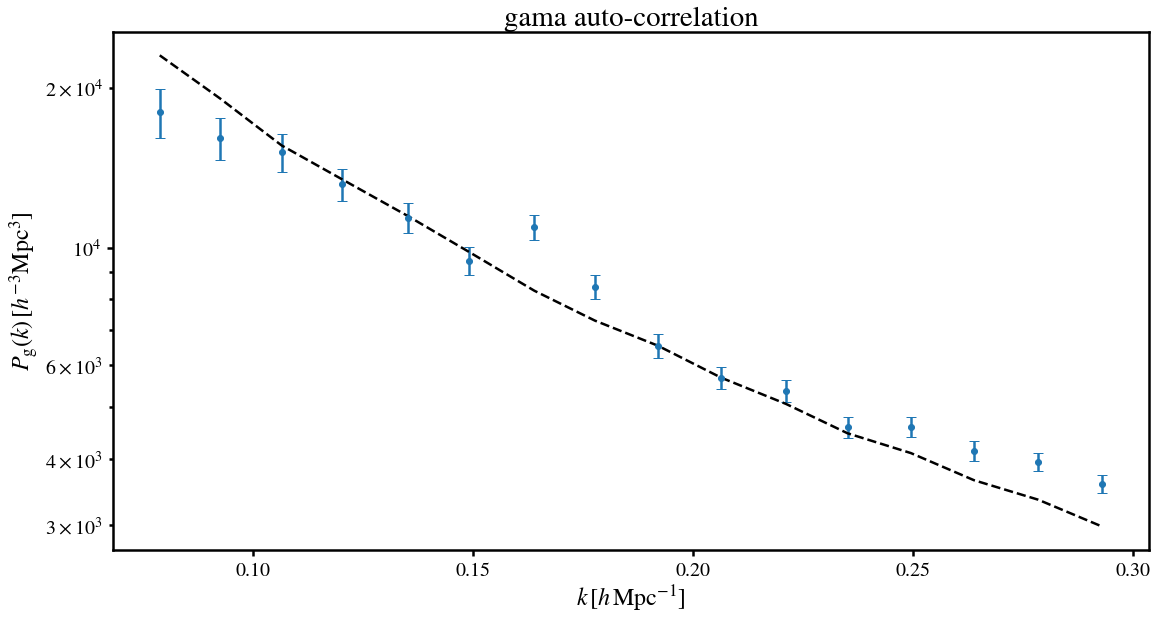

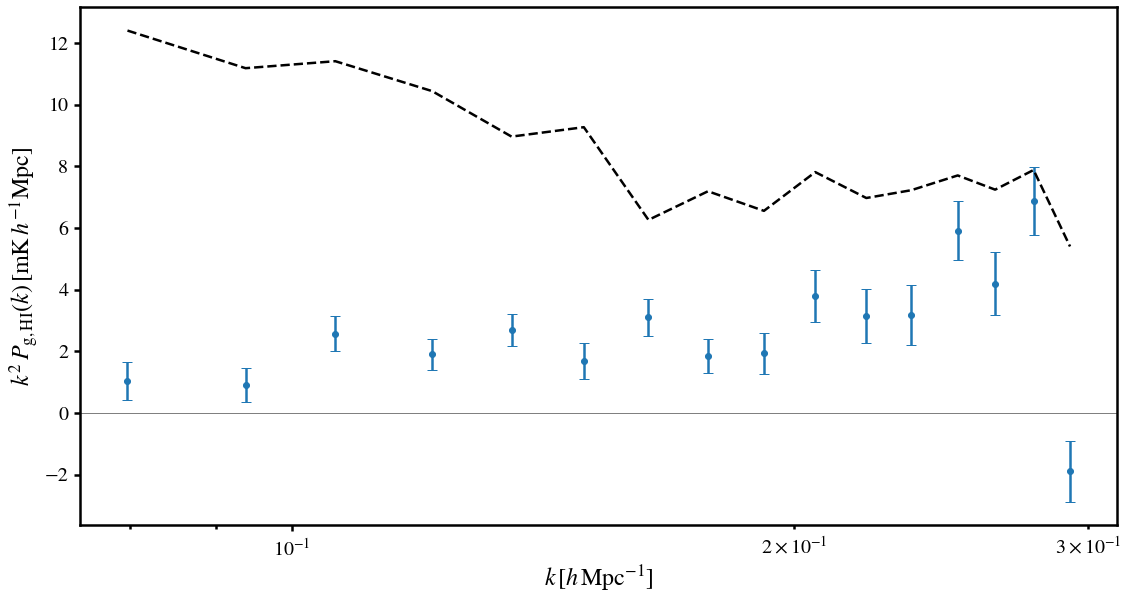

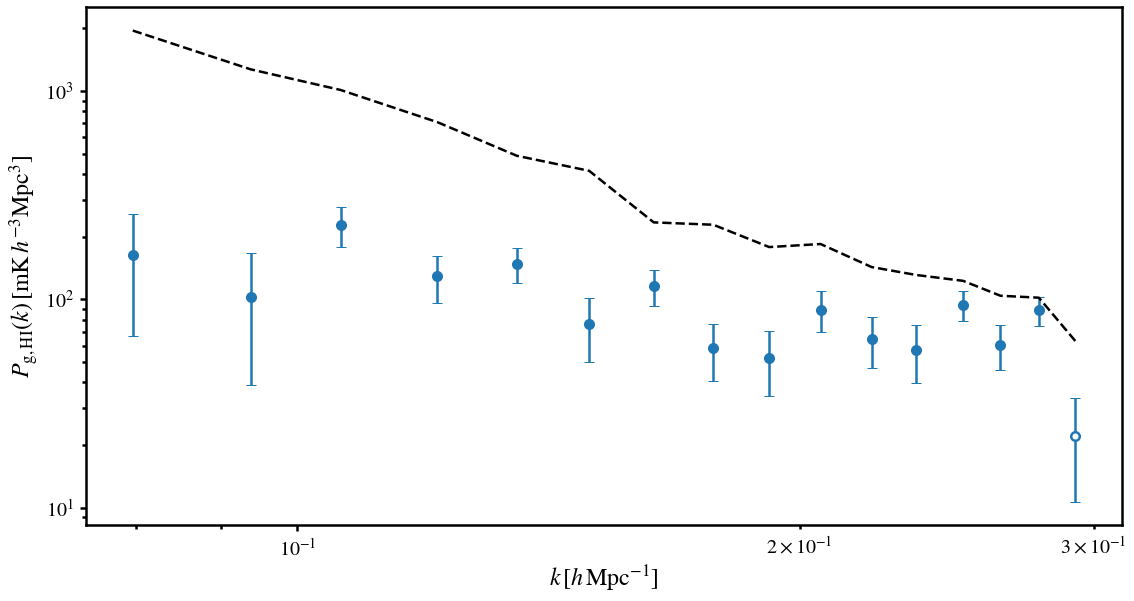

In [11]:
import power
import model
nkbin = 16
kmin,kmax = 0.07,0.3
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kcuts = [0.052,0.031,0.175,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)

if survey=='2019': kcuts = [0.052,0.031,0.14,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)

#kcuts = None

import model
sig_v = 200
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )


b_g = 1.9
sig_v_gal = 0


### Galaxy Auto-power (can use to constrain bias and use for analytical errors):
Pk_g,k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W_g_rg,W2=W_g_rg)
W_g_rg /= np.max(W_g_rg)
Vfrac = np.sum(W_g_rg)/(nx_rg*ny_rg*nz_rg)
nbar = np.sum(n_g_rg)/(lx*ly*lz*Vfrac) # Calculate number density inside survey footprint
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v_gal,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=w_g_rg,w2=w_g_rg,W1=W_g_rg,W2=W_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
sig_g = 1/np.sqrt(nmodes)*(Pk_g+P_SN)
plt.errorbar(k,Pk_g,sig_g,ls='none',marker='o')
plt.plot(k,pkmod,color='black',ls='--')
plt.yscale('log')
plt.title(gal_cat+' auto-correlation')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g}(k)\,[h^{-3}{\rm Mpc}^{3}]$')
plt.axhline(0,lw=0.8,color='black')
plt.show()

#'''
# Reassign N_fg for foreground cleaning if required:
N_fg = 10
MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
#'''

# Calculate auto and cross-power specs:
Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg,kcuts=kcuts)
Pk_gHI,k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_gHI**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate

if gamma is not None: 
    theta_FWHM_max,R_beam_max = telescope.getbeampars(D_dish,np.min(nu))
    R_beam_gam = R_beam_max * np.sqrt(gamma)
else: R_beam_gam = np.copy(R_beam)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=r,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix1=s_pix,s_para1=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]

plt.axhline(0,lw=1,color='gray')
plt.errorbar(k,k**2*Pk_gHI,k**2*sig_err,ls='none',marker='o')
plt.plot(k,k**2*pkmod,ls='--',color='black')
plt.xscale('log')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.figure()

plt.errorbar(k,np.abs(Pk_gHI),sig_err,ls='none',marker='o',markersize=10)
plt.scatter(k[Pk_gHI<0],np.abs(Pk_gHI[Pk_gHI<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.plot(k,pkmod,ls='--',color='black')
plt.loglog()
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^3]$')
plt.show()

# Calculate/Load Transfer function:
##### - use to correct signal loss, analyse covariance and assign errors:

Errors for the reconstructed power spectrum $P_{\rm rec}(k) = P_{\rm clean}(k)/T(k)$ are propagated from the transfer function distributions $T(k)+\Delta T_i(k)$ obtained from each $i$th mock. We assume the errors add in quadrature, hence $\Delta P_{{\rm rec},i}/P_{\rm rec} = \sqrt{(\Delta P_{{\rm clean},i}/P_{\rm clean})^2 + (\Delta T_i/T)^2}$. We assume all quantifiable error lies in the TF distribution, hence $\Delta P_{{\rm clean},i} = 0$ and therefore $\Delta P_{{\rm rec},i} = P_{\rm rec} \frac{{\Delta T},i}{T}$. The uncertainties for the error bars can then be obtained from the 68th percentile regions of the reconstructed power distribution $P_{{\rm rec},i}(k) = P_{\rm rec}(k) + \Delta P_{{\rm rec},i}(k)$ 

500


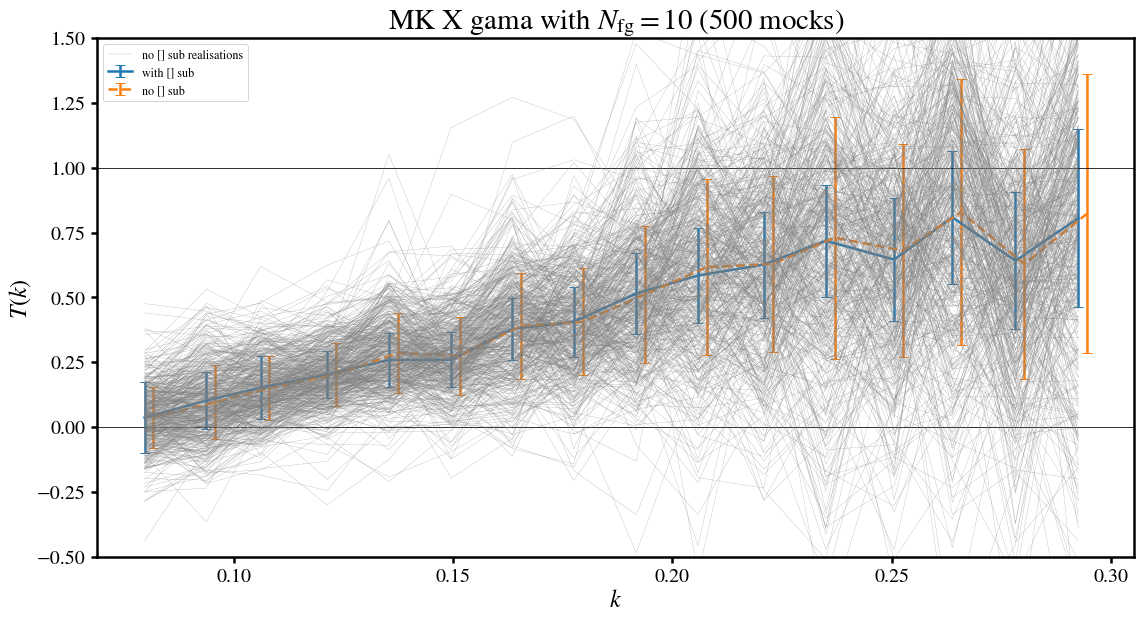

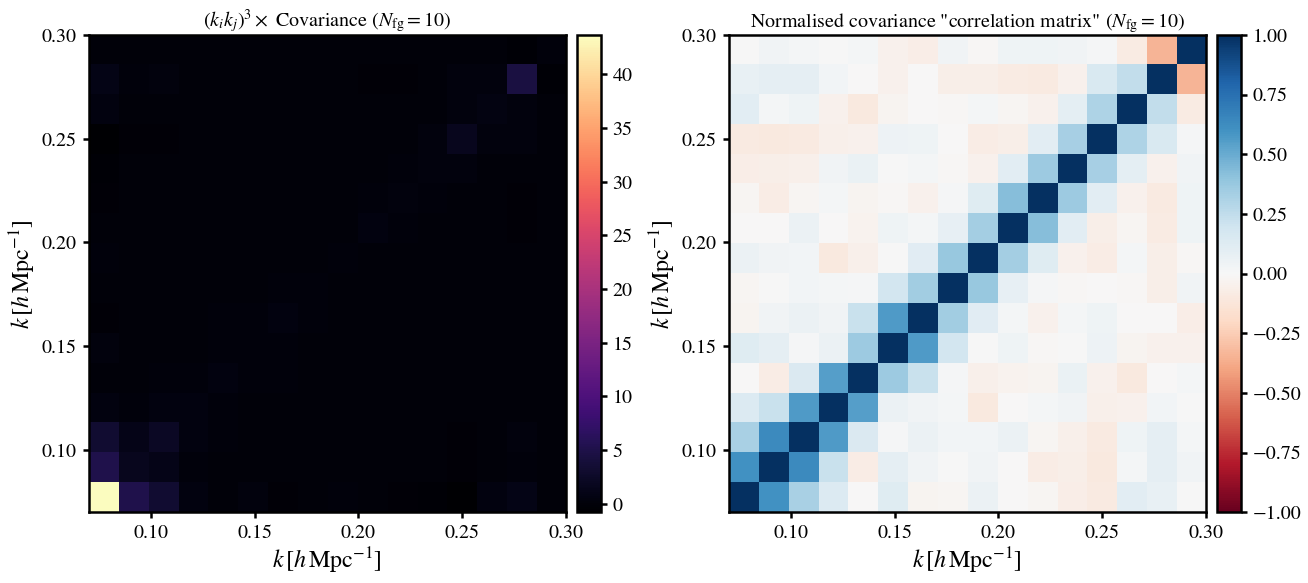

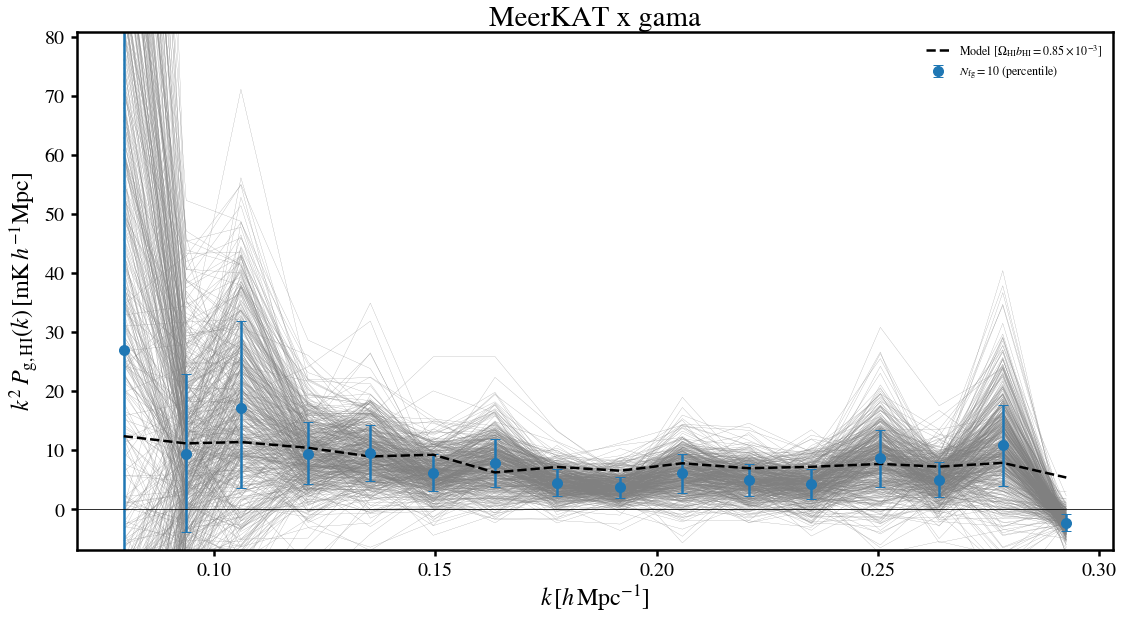

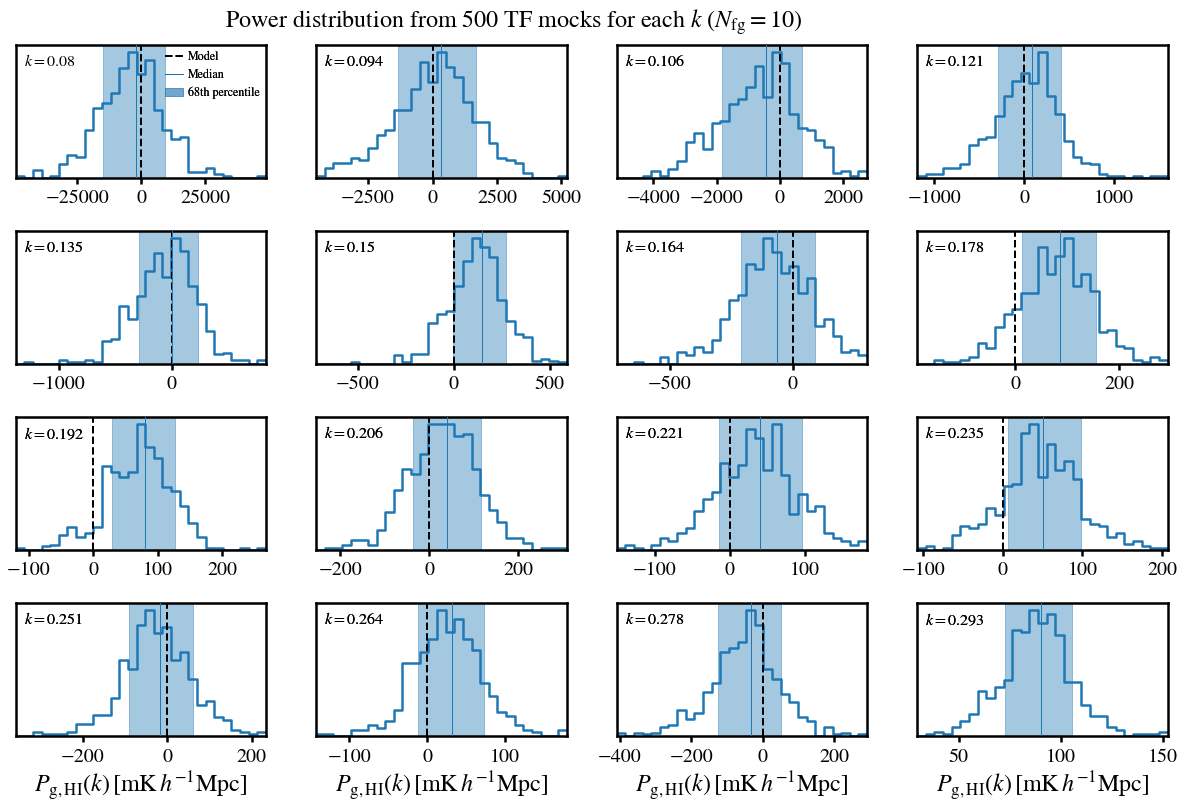

In [12]:
LoadTF = True
Nmock = 200
if gamma is None: gamma_label = 'None'
else: gamma_label = str(gamma)
if kcuts is None: kcuts_label = 'nokcuts'
else: kcuts_label = 'withkcuts'

#TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s_'%(N_fg,gamma_label)+kcuts_label
TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s_'%(N_fg,gamma_label)+kcuts_label+'_tukeyHI=%s'%tukey_alpha

mockfilepath_HI = '/idia/projects/hi_im/meerpower/'+survey+'Lband/mocks/dT_HI_p0.3d_wBeam'
if gal_cat=='wigglez': mockfilepath_g = '/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat'
if gal_cat=='cmass': mockfilepath_g = '/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat'
if gal_cat=='gama': mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
T_wsub_i, T_nosub_i,k  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fg,'Cross',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                            Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,gal_cat=gal_cat,
                                            gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                            w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,kcuts=kcuts,
                                            taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF)
T_wsub_i = np.array(T_wsub_i,dtype=np.float64)
T_nosub_i = np.array(T_nosub_i,dtype=np.float64)
k = np.array(k,dtype=np.float64)
Nmock = np.shape(T_wsub_i)[0]
print(Nmock)

T_i = np.copy(T_nosub_i)
T = np.mean(T_i,0)
deltaT_i = T_i - T
Pk_rec = Pk_gHI/T

### TF variance:
plt.axhline(0,lw=0.8,color='black')
plt.axhline(1,lw=0.8,color='black')
plt.errorbar(k,np.mean(T_wsub_i,0),np.std(T_wsub_i,0),label='with [] sub',zorder=0)
plt.errorbar(k+0.002,np.mean(T_nosub_i,0),np.std(T_nosub_i,0),label='no [] sub',ls='--',zorder=0)
for i in range(Nmock):
    if i==0: plt.plot(k,T_nosub_i[i],lw=0.2,color='gray',label='no [] sub realisations')
    else: plt.plot(k,T_nosub_i[i],lw=0.2,color='gray')
plt.legend(fontsize=12)
plt.title('MK X ' + gal_cat + r' with $N_{\rm fg}=%s$ (%s mocks)'%(N_fg,Nmock))
plt.xlabel(r'$k$')
plt.ylabel(r'$T(k)$')
plt.ylim(-0.5,1.5)
plt.show()

# Propagate error on TF into error on power:
deltaPk_i =  Pk_rec * (deltaT_i/T) 
Pk_rec_i = Pk_rec + deltaPk_i # corrected power uncertainty distribution
# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(deltaPk_i,15.865,axis=0))
upper_error = np.abs(np.percentile(deltaPk_i,84.135,axis=0))
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

# k-bin covariance/correlation matrices from TF:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,9))
from mpl_toolkits.axes_grid1 import make_axes_locatable
kgrid = k * k[:,np.newaxis]
C = kgrid**3*np.cov(Pk_rec_i,rowvar=False)
im = ax[0].imshow(C,origin='lower',extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
ax[0].set_xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_title(r'$(k_ik_j)^3\times$ Covariance ($N_{\rm fg}=%s$)'%N_fg,fontsize=20)
# Noramlised k-bin correlation matrix:
R = np.corrcoef(Pk_rec_i,rowvar=False)
im = ax[1].imshow(R,origin='lower',cmap='RdBu',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
ax[1].set_xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
ax[1].set_ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_title(r'Normalised covariance "correlation matrix" ($N_{\rm fg}=%s$)'%N_fg,fontsize=20)
plt.subplots_adjust(wspace=0.25)
plt.show()

# Plot results, correcting for signal loss and with TF-based errors:
# Chose factorisation of P(k) in plotting:
norm = np.ones(nkbin)
#norm = k**2

for i in range(Nmock):
    plt.plot(k,k**2*Pk_rec_i[i],lw=0.2,color='gray',zorder=-1)
plt.errorbar(k,k**2*Pk_rec,k**2*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (percentile)'%N_fg,markersize=10)
#plt.errorbar(k*1.01,k**2*Pk_rec,k**2*np.std(Pk_X/T_nosub,0),ls='none',marker='o',label=r'$N_{\rm fg}=%s$ (rms)'%N_fgs[indx_choice],markersize=10,alpha=0.5)
plt.plot(k,k**2*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.axhline(0,lw=0.8,color='black')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.title('MeerKAT x ' + gal_cat)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.ylim(-3*np.abs(np.min(k**2*Pk_rec)),3*np.max(k**2*Pk_rec))
plt.show()

### Histogram of TF mock distributions to show error profile for each k-bin:
np.save('/idia/projects/hi_im/meerpower/allLband/data/Pk_rec_i_%s_%s_Nfg=%s.npy'%(gal_cat,kcuts_label,N_fg),Pk_rec_i)
nrows = int(nkbin/4)
fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(20,12))
k_ind = 0
for row in ax:
    for col in row:
        if k_ind==nkbin: break
        dum, = col.plot(0,label=r'$k=%s$'%np.round(k[k_ind],3),color='white') # dummy line to show k-value in legend
        legend1 = col.legend([dum], [r'$k=%s$'%np.round(k[k_ind],3)], loc='upper left',fontsize=16,handlelength=0,handletextpad=0,frameon=False,borderaxespad=0.1)
        col.add_artist(legend1)
        #mod = col.axvline(pkmod[k_ind],color='black',ls='--',lw=2,zorder=8)
        mod = col.axvline(0,color='black',ls='--',lw=2,zorder=8)
        median = col.axvline(np.median(pkmod[k_ind]-Pk_rec_i[:,k_ind]),color='tab:blue',ls='-',lw=1,zorder=9)
        span = col.axvspan(np.percentile(pkmod[k_ind]-Pk_rec_i[:,k_ind],50-34.1,axis=0), np.percentile(pkmod[k_ind]-Pk_rec_i[:,k_ind],50+34.1,axis=0), alpha=0.4, color='tab:blue',zorder=-10,label='68th percentile')
        if k_ind==0:
            legend2 = col.legend([mod,median,span], ['Model','Median','68th percentile'], loc='upper right',fontsize=12,frameon=False,handlelength=1.5,handletextpad=0.4,borderaxespad=0.1)
            col.add_artist(legend2)
        hist,bins = np.histogram(pkmod[k_ind]-Pk_rec_i[:,k_ind],bins=30)
        bins = (bins[1:] + bins[:-1])/2
        col.plot(bins,hist,ds='steps')
        col.set_xlim(bins[0],bins[-1])
        col.set_ylim(0)
        col.set_yticks([])
        if k_ind>=12: col.set_xlabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
        k_ind += 1
plt.subplots_adjust(hspace=0.4)
plt.suptitle(r'Power distribution from %s TF mocks for each $k$ ($N_{\rm fg}=%s$)'%(Nmock,N_fg))
plt.show()




# Least-squares best fit $\Omega_{\rm HI}b_{\rm HI}r$ and $\chi^2$ , detection significance analysis:


----------------------------------------------
---- (fiducial OmegaHI & diagonal covariance):

Fiducial OmegaHIbHIr x 10^3 =  0.85

Reduced Chi^2: 0.5497649321376177

Detection Significance: 5.638 sigma

----------------------------------------------
---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.889 +/- 0.075

Reduced Chi^2 :0.235321613112445

Detection Significance: 5.989 sigma

----------------------------------------------
---- (fiducial OmegaHI & full covariance):

Fiducial OmegaHIbHIr x 10^3 =  0.85

Reduced Chi^2 :0.3429569830849354

Detection Significance: 4.128 sigma

----------------------------------------------
---- (fitted OmegaHI & full covariance):

OmegaHIbHIr x 10^3 =  0.778 +/- 0.112

Reduced Chi^2 :0.331567770850648

Detection Significance: 4.146 sigma


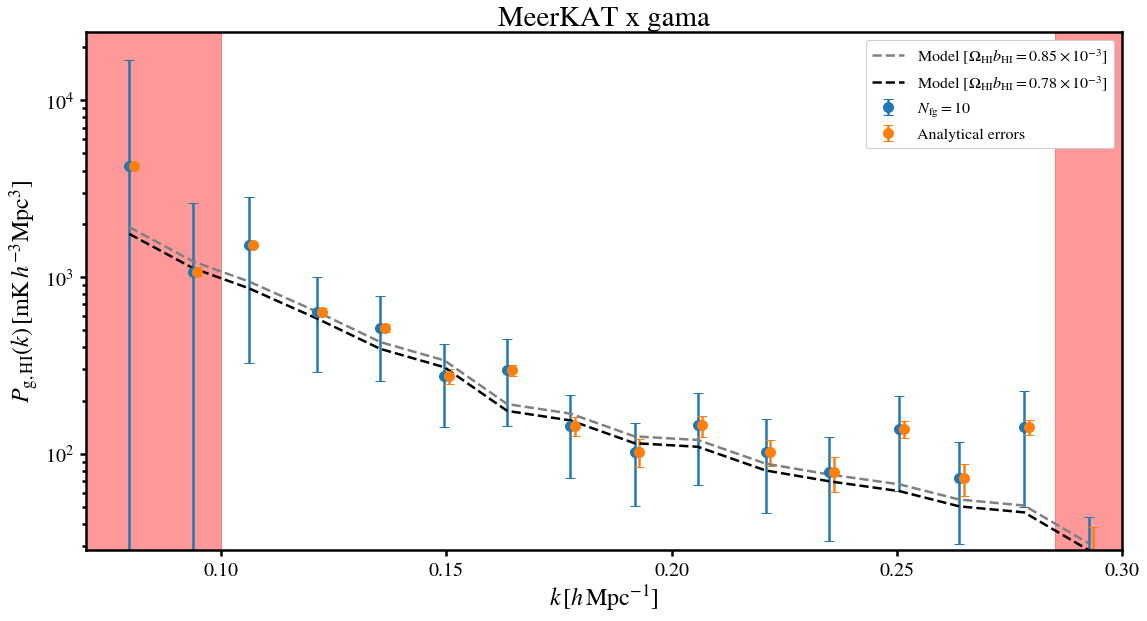

In [13]:
if gal_cat=='cmass': kbin_cut = (k>0.09) & (k<0.25)
if gal_cat=='gama': kmincut,kmaxcut = 0.1,0.285

kbin_cut = (k>kmincut) & (k<kmaxcut) # untrusted k-bins to cut

sig_v = 400

### Chi-squared and detection significance for fiducial OmegaHI and diagonal covariance:
print('\n----------------------------------------------\n---- (fiducial OmegaHI & diagonal covariance):')
print('\nFiducial OmegaHIbHIr x 10^3 = ',str(np.round(1e3*OmegaHIbHI,3)))
print('\nReduced Chi^2: ' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod[kbin_cut],np.std(Pk_rec_i,0)[kbin_cut],dof=len(k[kbin_cut]))))
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod[kbin_cut],np.std(Pk_rec_i,0)[kbin_cut])
OmegaHI = OmegaHIbHI/b_HI
Tbar = HItools.Tbar(zeff,OmegaHI)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix1=s_pix,s_pix2=0,s_para1=s_para,s_para2=0,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]

### Now get best-fit OmegaHI:
# Diagonal covariance:      
OmHIbHIr_fit, sigma_OmHIbHIr = model.LSqFitPkAmplitude(Pk_rec,np.std(Pk_rec_i,0),Pmod,zeff,dims_rg,kbins,corrtype='Cross',P_N_=0,kmin=kmincut,kmax=kmaxcut,b2=b_g,f=f,sig_v=sig_v,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para)
OmegaHI_fit = OmHIbHIr_fit/b_HI
Tbar_fit = HItools.Tbar(zeff,OmegaHI_fit)
pkmod_fit,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix1=s_pix,s_pix2=0,s_para1=s_para,s_para2=0,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
print('\n----------------------------------------------\n---- (fitted OmegaHI & diagonal covariance):')
print('\nOmegaHIbHIr x 10^3 = ',str(np.round(1e3*OmHIbHIr_fit,3)), '+/-', str(np.round(1e3*sigma_OmHIbHIr,3)))
print('\nReduced Chi^2 :' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod_fit[kbin_cut],np.std(Pk_rec_i,0)[kbin_cut],dof=len(k[kbin_cut]))))
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod_fit[kbin_cut],np.std(Pk_rec_i,0)[kbin_cut])

# Full covariance (fiducial OmegaHI):      
print('\n----------------------------------------------\n---- (fiducial OmegaHI & full covariance):')
print('\nFiducial OmegaHIbHIr x 10^3 = ',str(np.round(1e3*OmegaHIbHI,3)))
C = np.cov(Pk_rec_i,rowvar=False)
C = C[kbin_cut]
C = C[:,kbin_cut]
print('\nReduced Chi^2 :' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod[kbin_cut],C,dof=len(k[kbin_cut]))))
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod[kbin_cut],C)

# Full covariance (fitted OmegaHI):      
OmHIbHIr_fit, sigma_OmHIbHIr = model.LSqFitPkAmplitude(Pk_rec,np.cov(Pk_rec_i,rowvar=False),Pmod,zeff,dims_rg,kbins,corrtype='Cross',P_N_=0,kmin=kmincut,kmax=kmaxcut,b2=b_g,f=f,sig_v=sig_v,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para)
OmegaHI_fit = OmHIbHIr_fit/b_HI
Tbar_fit = HItools.Tbar(zeff,OmegaHI_fit)
pkmod_fit,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix1=s_pix,s_pix2=0,s_para1=s_para,s_para2=0,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
print('\n----------------------------------------------\n---- (fitted OmegaHI & full covariance):')
print('\nOmegaHIbHIr x 10^3 = ',str(np.round(1e3*OmHIbHIr_fit,3)), '+/-', str(np.round(1e3*sigma_OmHIbHIr,3)))
print('\nReduced Chi^2 :' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod_fit[kbin_cut],C,dof=len(k[kbin_cut]))))
det_sig = model.DetectionSigma(Pk_rec[kbin_cut],pkmod_fit[kbin_cut],C)

plt.errorbar(k,norm*np.abs(Pk_rec),norm*asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fg,markersize=10)
plt.scatter(k[Pk_rec<0],norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
plt.errorbar(k+0.001,norm*np.abs(Pk_rec),norm*sig_err,ls='none',marker='o',label='Analytical errors',markersize=10,color='tab:orange')
plt.scatter(k[Pk_rec<0]+0.001,norm[Pk_rec<0]*np.abs(Pk_rec[Pk_rec<0]),marker='o',facecolors='white',color='tab:orange',zorder=10,s=50)
plt.plot(k,norm*pkmod,color='gray',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHIbHI*1e3,2))
plt.plot(k,norm*pkmod_fit,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmHIbHIr_fit*1e3,2))
if norm[0]==1.0: plt.yscale('log')
plt.axhline(0,lw=0.8,color='black')
plt.axvspan(kbins[0],kmincut,color='red',alpha=0.4)
plt.axvspan(kmaxcut,kbins[-1],color='red',alpha=0.4)
plt.xlim(kbins[0],kbins[-1])
plt.ylim(bottom=np.min(norm*pkmod_fit))
plt.legend(fontsize=16,loc='upper right',frameon=True,framealpha=1)
plt.title('MeerKAT x ' + gal_cat)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.show()


# Run MCMC to sanity check model fitting:

You must install the tqdm library to use progress indicators with emcee



Running production...


You must install the tqdm library to use progress indicators with emcee



Running production...


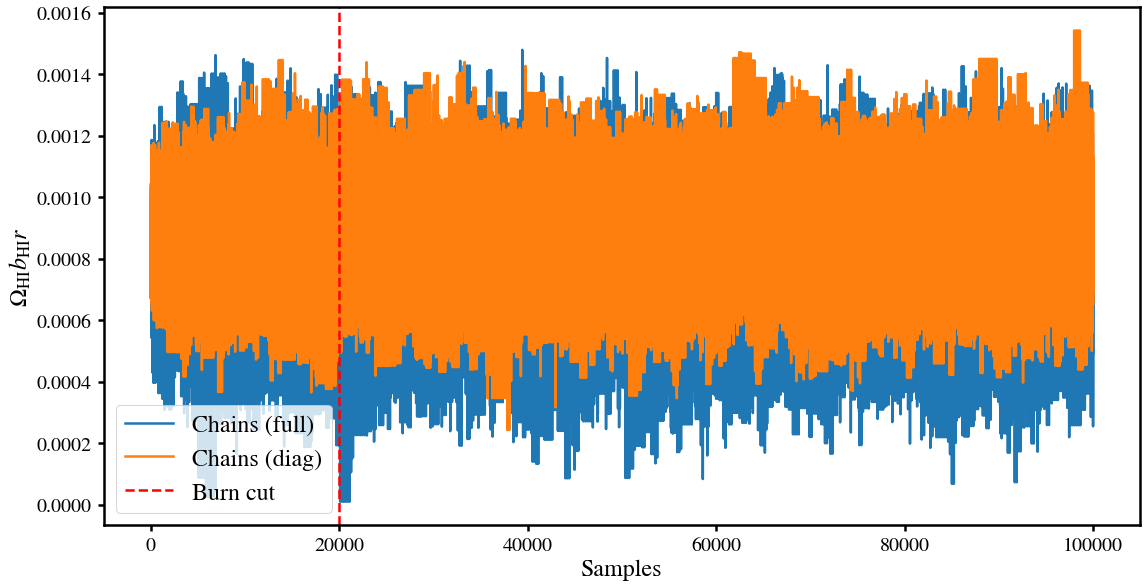

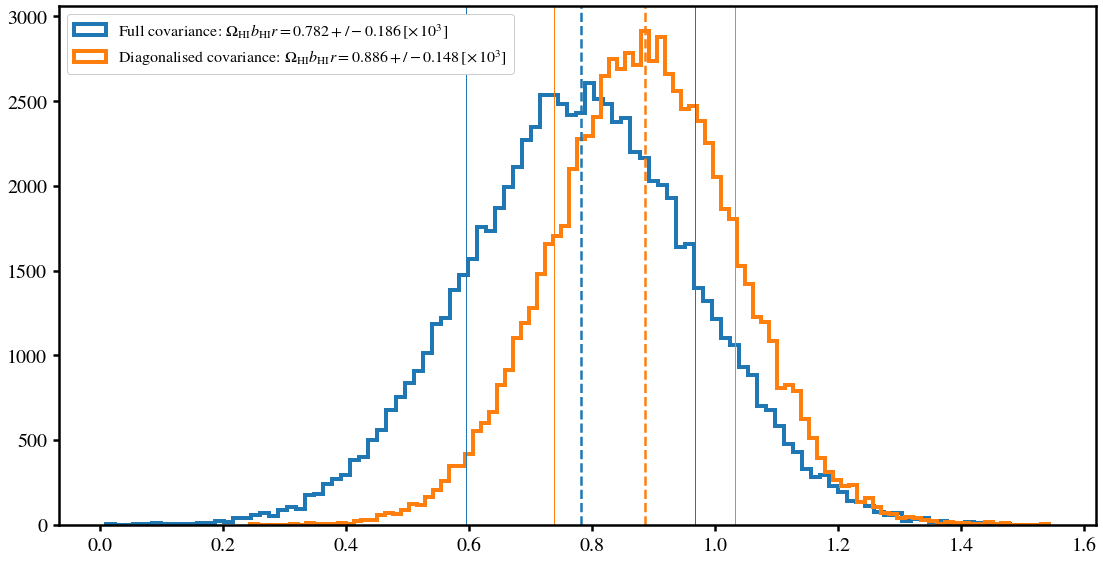

In [14]:
import emcee
nwalkers = 200
niter = 500
nburn = 40
ContinueBackend = False

### Full covariance:
backendfile = '/idia/projects/hi_im/meerpower/allLband/MKxGAMAOmHIbHI_fullcov.h5'
Pkerr = np.cov(Pk_rec_i,rowvar=False)
samples = model.runOmHIbHIrMCMC(k,Pk_rec,Pkerr,Pmod,Omega_HI_fid=OmegaHIbHI,b_HI_fid=1,zeff_=zeff,f=f,sig_v=sig_v,R_beam=R_beam_gam,dims_rg=dims_rg,kbins=kbins,kmincut=kmincut,kmaxcut=kmaxcut,r=1,b_g=b_g,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,nwalkers=nwalkers,niter=niter,ContinueBackend=ContinueBackend,backendfile=backendfile)
reader = emcee.backends.HDFBackend(backendfile)
samples = reader.get_chain(flat=True)
OmHI_samp = samples[:,0]
OmHI_samp = OmHI_samp[nburn*niter:]
OmHI_low = np.percentile(OmHI_samp,50-34.1)*1e3
OmHI_med = np.percentile(OmHI_samp,50)*1e3
OmHI_upp = np.percentile(OmHI_samp,50+34.1)*1e3
OmHI_std = np.std(OmHI_samp)*1e3

### Diagonal covariance:
backendfile = '/idia/projects/hi_im/meerpower/allLband/MKxGAMAOmHIbHI_diagcov.h5'
Pkerr = np.std(Pk_rec_i,0)
samples_diag = model.runOmHIbHIrMCMC(k,Pk_rec,Pkerr,Pmod,Omega_HI_fid=OmegaHIbHI,b_HI_fid=1,zeff_=zeff,f=f,sig_v=sig_v,R_beam=R_beam_gam,dims_rg=dims_rg,kbins=kbins,kmincut=kmincut,kmaxcut=kmaxcut,r=1,b_g=b_g,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,nwalkers=nwalkers,niter=niter,ContinueBackend=ContinueBackend,backendfile=backendfile)
reader = emcee.backends.HDFBackend(backendfile)
samples_diag = reader.get_chain(flat=True)
OmHI_samp_diag = samples_diag[:,0]
OmHI_samp_diag = OmHI_samp_diag[nburn*niter:]
OmHI_low_diag = np.percentile(OmHI_samp_diag,50-34.1)*1e3
OmHI_med_diag = np.percentile(OmHI_samp_diag,50)*1e3
OmHI_upp_diag = np.percentile(OmHI_samp_diag,50+34.1)*1e3
OmHI_std_diag = np.std(OmHI_samp_diag)*1e3

# Check chain convergence:
plt.plot(samples,label='Chains (full)')
plt.plot(samples_diag,label='Chains (diag)')
plt.axvline(nburn*niter,color='red',ls='--',label='Burn cut')
plt.legend()
plt.xlabel('Samples')
plt.ylabel(r'$\Omega_{\rm HI} b_{\rm HI} r$')
plt.show()

### Compare posteriors for full and diagonal covariance:
plt.hist(1e3*OmHI_samp,bins=100,histtype='step',lw=4,label=r'Full covariance: $\Omega_{\rm HI} b_{\rm HI} r =%s +/- %s \, [\times\,10^3]$'%(np.round(OmHI_med,3),np.round(OmHI_std,3)))
plt.hist(1e3*OmHI_samp_diag,bins=100,histtype='step',lw=4,label=r'Diagonalised covariance: $\Omega_{\rm HI} b_{\rm HI} r =%s +/- %s \, [\times\,10^3]$'%(np.round(OmHI_med_diag,3),np.round(OmHI_std_diag,3)))
plt.axvline(OmHI_med,ls='--',color='tab:blue')
plt.axvline(OmHI_low,ls='-',lw=1,color='tab:blue')
plt.axvline(OmHI_upp,ls='-',lw=1,color='tab:blue')
plt.axvline(OmHI_med_diag,ls='--',color='tab:orange')
plt.axvline(OmHI_low_diag,ls='-',lw=1,color='tab:orange')
plt.axvline(OmHI_upp_diag,ls='-',lw=1,color='tab:orange')
plt.legend(fontsize=16,framealpha=1)
plt.show()


# Analyse the HI auto power:


Generating noise realisations:
[==============================] 100%

(500, 16)


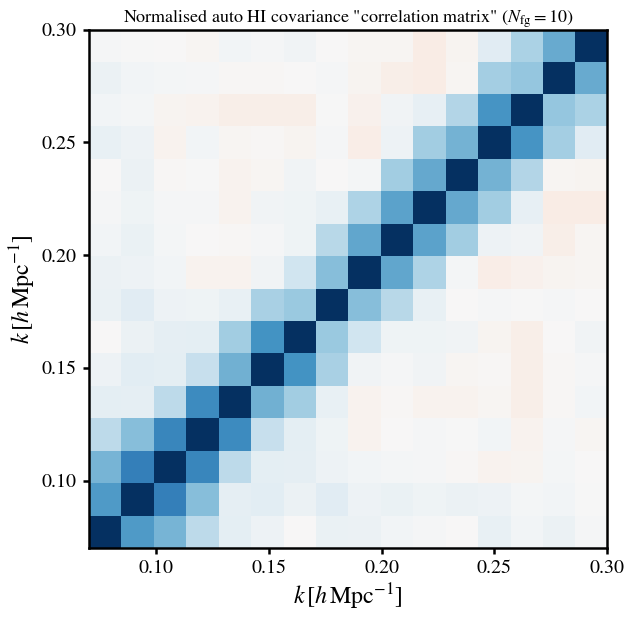


Detection Significance: 1.118 sigma

Detection Significance: 1.673 sigma

Detection Significance: 0.78 sigma


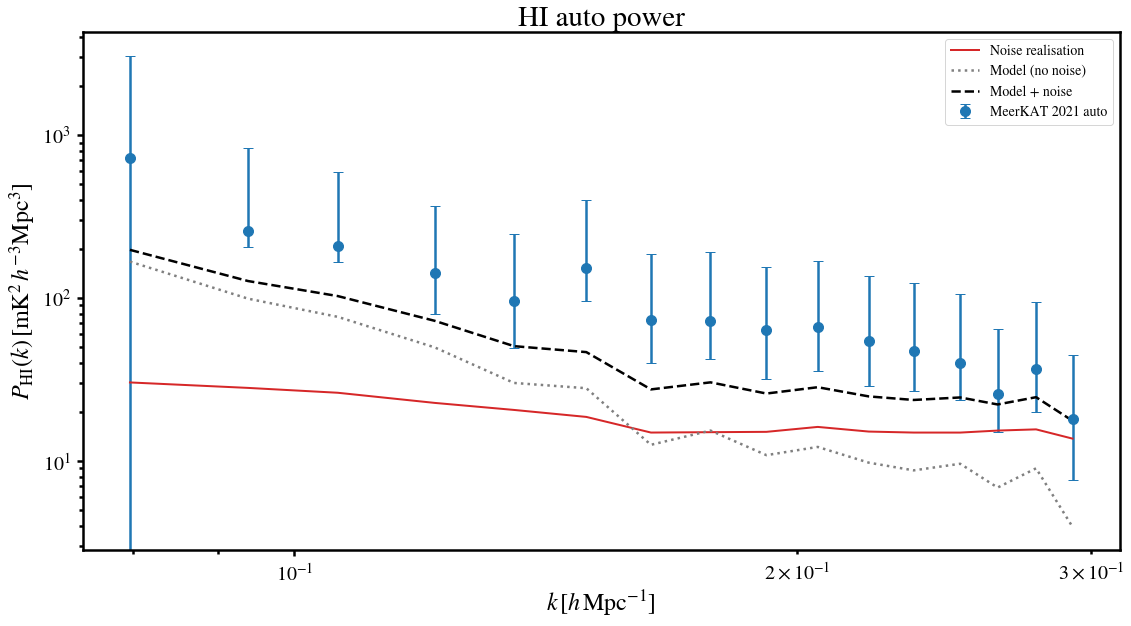

/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [15]:
### Plot HI auto and model with noise:

# Generate and regrid forecast thermal noise map to Cartesian field and measure power:
Nnoisemap = 10
T_sys = None
#T_sys = 15e3 #[mK]
Pk_N = np.zeros((Nnoisemap,len(k)))
for i in range(Nnoisemap):
    plot.ProgressBar(i,Nnoisemap,header='Generating noise realisations:')
    noisemap = telescope.gen_noise_map(counts_HI,W_HI,nu,T_sys=T_sys)
    if gamma is not None: noisemap,null = telescope.weighted_reconvolve(noisemap,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=noisemap,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    noisemap_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    Pk_N[i],k,nmodes = power.Pk(noisemap_rg,noisemap_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg,kcuts=kcuts)
Pk_N = np.mean(Pk_N,0)

# HI auto power TF:
#TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_HIauto_Nfg=%s_gamma=%s_'%(N_fg,gamma_label)+kcuts_label
TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_HIauto_Nfg=%s_gamma=%s_'%(N_fg,gamma_label)+kcuts_label+'_tukeyHI=%s'%tukey_alpha

T_HIauto_wsub_i, T_HIauto_nosub_i,k  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fg,'HIauto',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                            Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,gal_cat=gal_cat,
                                            gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                            w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,kcuts=kcuts,
                                            taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF)

# kcuts, error propagation and detection significance:
kmincut_HI,kmaxcut_HI = 0,0.2
kbin_cut_HI = (k>kmincut_HI) & (k<kmaxcut_HI) # untrusted k-bins to cut

print(np.shape(T_HIauto_nosub_i))
T_HIauto_i = np.copy(T_HIauto_nosub_i)
T_HIauto = np.mean(T_HIauto_i,0)
deltaT_HIauto_i = T_HIauto_i - T_HIauto
PkHI_rec = Pk_HI/T_HIauto
# Propagate error on TF into error on power:
deltaPkHI_i =  PkHI_rec * (deltaT_HIauto_i/T_HIauto) 
PkHI_rec_i = PkHI_rec + deltaPkHI_i # corrected power uncertainty distribution
# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(PkHI_rec_i,15.865,axis=0))
upper_error = np.abs(np.percentile(PkHI_rec_i,84.135,axis=0))
asymmetric_HIerror = np.array(list(zip(lower_error, upper_error))).T

C_HIauto = np.cov(PkHI_rec_i,rowvar=False)
C_HIauto = C_HIauto[kbin_cut_HI]
C_HIauto = C_HIauto[:,kbin_cut_HI]
R = np.corrcoef(PkHI_rec_i,rowvar=False)
plt.imshow(R,origin='lower',cmap='RdBu',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.title(r'Normalised auto HI covariance "correlation matrix" ($N_{\rm fg}=%s$)'%N_fg,fontsize=18)
plt.show()

OmHIbHIr_fit = 0.85e-3 # MKxWiggleZ constraint
r = 0.9
OmegaHI_fit = OmHIbHIr_fit/b_HI/r
Tbar_fit = HItools.Tbar(zeff,OmegaHI_fit)
sig_v_HI = 0
pkmod_HI,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_HI,f,sig_v_HI,Tbar1=Tbar_fit,Tbar2=Tbar_fit,r=1,R_beam1=R_beam_gam,R_beam2=R_beam_gam,w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg,kcuts=kcuts,s_pix1=s_pix,s_pix2=s_pix,s_para1=s_para,s_para2=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
det_sig = model.DetectionSigma(PkHI_rec[kbin_cut_HI],pkmod_HI[kbin_cut_HI]+Pk_N[kbin_cut_HI],np.mean(asymmetric_error,0)[kbin_cut_HI],nullmodel=Pk_N[kbin_cut_HI])
det_sig = model.DetectionSigma(PkHI_rec[kbin_cut_HI],pkmod_HI[kbin_cut_HI]+Pk_N[kbin_cut_HI],C_HIauto,nullmodel=Pk_N[kbin_cut_HI])
## Calculate the maximum sigma detection obtainable by assuming data and model agree 100%:
det_sig = model.DetectionSigma(pkmod_HI[kbin_cut_HI]+Pk_N[kbin_cut_HI],pkmod_HI[kbin_cut_HI]+Pk_N[kbin_cut_HI],C_HIauto,nullmodel=Pk_N[kbin_cut_HI])

plt.errorbar(k,PkHI_rec,asymmetric_HIerror,ls='none',marker='o',markersize=10,label='MeerKAT ' + survey + ' auto')
plt.plot(k,Pk_N,lw=2,color='tab:red',label='Noise realisation')
plt.plot(k,pkmod_HI,ls=':',color='gray',label='Model (no noise)')
plt.plot(k,pkmod_HI+Pk_N,ls='--',color='black',label='Model + noise')
plt.loglog()
plt.legend(fontsize=14)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^3]$')
plt.title('HI auto power')
plt.show()
np.save('/idia/projects/hi_im/meerpower/allLband/data/HIautoPk_%s_%s_Nfg=%s.npy'%(gal_cat,kcuts_label,N_fg),[k,pkmod_HI,Pk_N,PkHI_rec,asymmetric_HIerror])


# Analyse power, TF and S/N in 2D-cylindrical $k_\perp,k_\parallel$ space

500


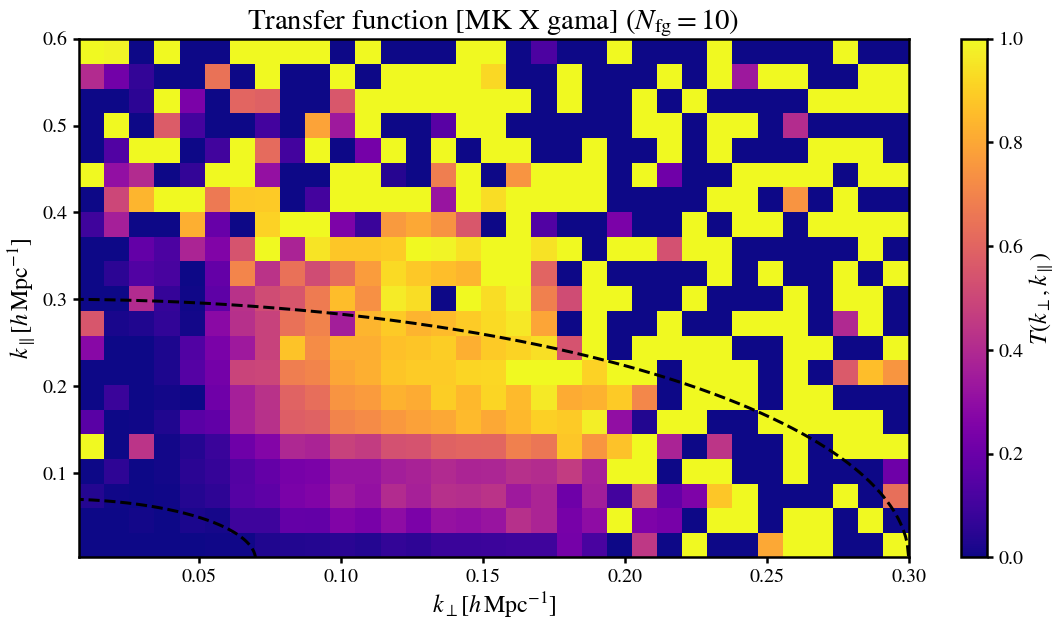

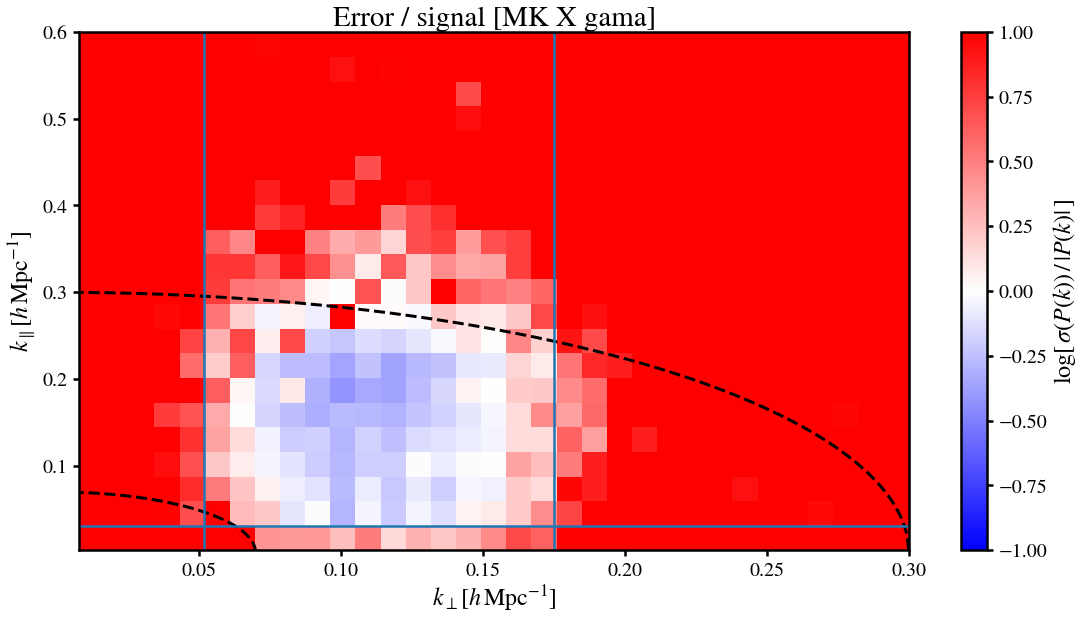

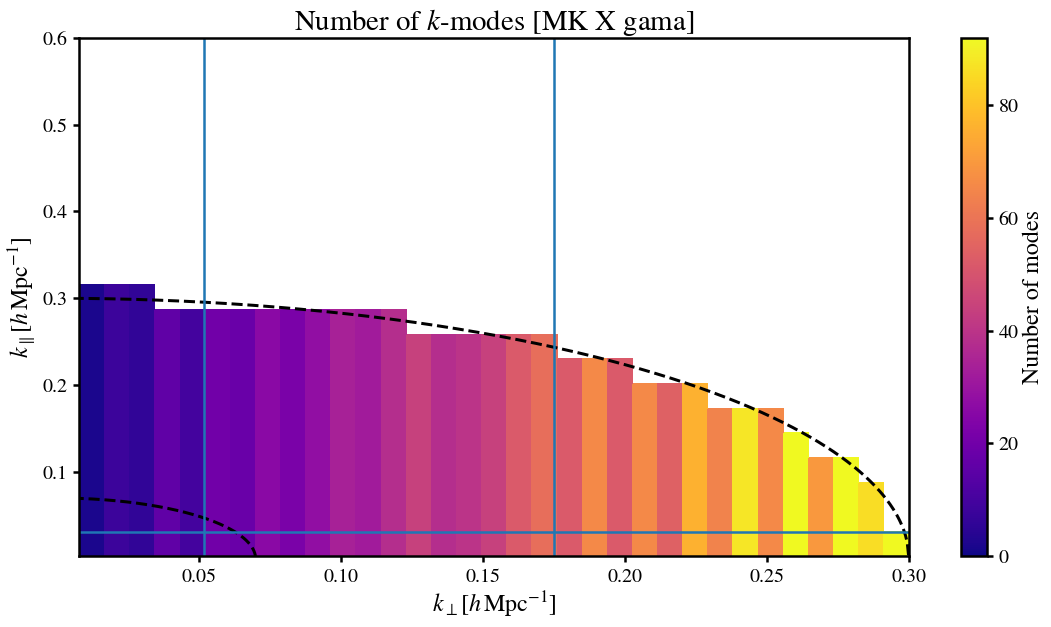

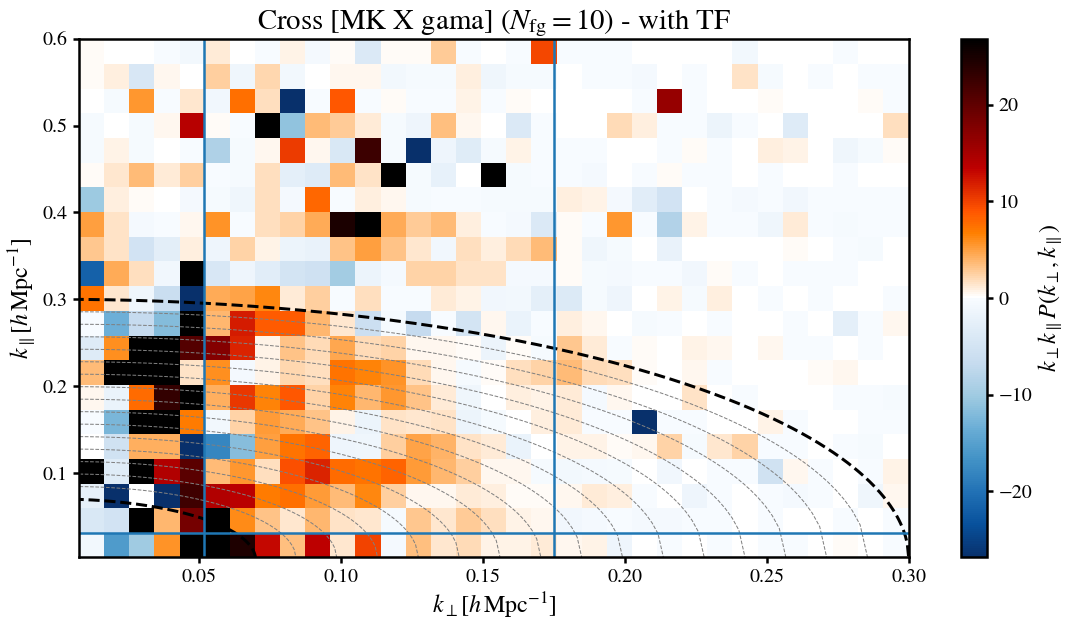

In [16]:
kperpbins = np.linspace(0.008,0.3,34)
kparabins = np.linspace(0.003,0.6,22)

LoadTF = True
Nmock = 200
if gamma is None: gamma_label = 'None'
else: gamma_label = str(gamma)

#TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T2D_Nfg=%s_gamma=%s_'%(N_fg,gamma_label)
TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T2D_Nfg=%s_gamma=%s'%(N_fg,gamma_label)+'_tukeyHI=%s'%tukey_alpha


mockfilepath_HI = '/idia/projects/hi_im/meerpower/'+survey+'Lband/mocks/dT_HI_p0.3d_wBeam'
if gal_cat=='wigglez': mockfilepath_g = '/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat'
if gal_cat=='cmass': mockfilepath_g = '/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat'
if gal_cat=='gama': mockfilepath_g = '/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat'
T2d_wsub_i, T2d_nosub_i,k2d  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fg,'Cross',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                            Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,gal_cat=gal_cat,
                                            gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                            w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,kcuts=kcuts,
                                            taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF,TF2D=True,kperpbins=kperpbins,kparabins=kparabins)

Nmock = np.shape(T2d_nosub_i)[0]
print(Nmock)
plt.pcolormesh(kperpbins,kparabins,np.mean(T2d_wsub_i,0),vmin=0,vmax=1,cmap='plasma')
### 1D k_min contour:
kperp_formin = np.linspace(0,kmin,500)
kpara_formin = np.linspace(0,kmin,500)
kcontmin = np.sqrt(kmin**2 - kpara_formin**2)
plt.plot(kperp_formin,kcontmin,color='black',ls='--',lw=3)
### 1D k_max contour:
kperp_formax = np.linspace(0,kmax,500)
kpara_formax = np.linspace(0,kmax,500)
kcontmax = np.sqrt(kmax**2 - kpara_formax**2)
plt.plot(kperp_formax,kcontmax,color='black',ls='--',lw=3)
plt.colorbar(label=r'$T(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Transfer function [MK X ' + gal_cat + r'] ($N_{\rm fg}=%s$) '%N_fg)
plt.show()

Pk2d,k2d,nmodes2d = power.Pk2D(MKmap_clean_rg,n_g_rg,dims_rg,kperpbins,kparabins,'Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg)
T2d_i = np.copy(T2d_wsub_i)
T2d = np.mean(T2d_i,0)
deltaT2d_i = T2d_i - T2d
Pk2d_rec = Pk2d/T2d

# Propagate error on TF into error on power:
deltaPk2d_i =  Pk2d_rec * (deltaT2d_i/T2d) 
Pk2d_rec_i = Pk2d_rec + deltaPk2d_i # corrected power uncertainty distribution
SNR = np.abs(Pk2d_rec) / np.std(Pk2d_rec_i,0)
#plt.pcolormesh(kperpbins,kparabins,1/SNR,vmin=0,vmax=5)
plt.pcolormesh(kperpbins,kparabins,np.log10(1/SNR),vmin=-1,vmax=1,cmap='bwr')
plt.plot(kperp_formin,kcontmin,color='black',ls='--',lw=3)
plt.plot(kperp_formax,kcontmax,color='black',ls='--',lw=3)
if kcuts is not None:
    if kcuts[0] is not None: plt.axvline(kcuts[0])
    if kcuts[2] is not None: plt.axvline(kcuts[2])
    if kcuts[1] is not None: plt.axhline(kcuts[1])
    if kcuts[3] is not None: plt.axhline(kcuts[3])
plt.colorbar(label=r'log[$\,\sigma(P(k))\,/\,|P(k)|\,$]')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title('Error / signal [MK X ' + gal_cat + r']')
plt.show()

### Plot Nmodes:
nmodes2d = nmodes2d.astype(np.float32) # change to floats so can assign nans to masked modes
nmodes2d[k2d>kmax] = np.nan
plt.pcolormesh(kperpbins,kparabins,nmodes2d,vmin=0,cmap='plasma')
plt.plot(kperp_formin,kcontmin,color='black',ls='--',lw=3)
plt.plot(kperp_formax,kcontmax,color='black',ls='--',lw=3)
if kcuts is not None:
    if kcuts[0] is not None: plt.axvline(kcuts[0])
    if kcuts[2] is not None: plt.axvline(kcuts[2])
    if kcuts[1] is not None: plt.axhline(kcuts[1])
    if kcuts[3] is not None: plt.axhline(kcuts[3])
plt.colorbar(label='Number of modes')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title('Number of $k$-modes [MK X ' + gal_cat + r']')
plt.show()

kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]
### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
if kcuts is not None: kcuts2d = (k2d>kmin) & (k2d<kmax) & (kperpgrid>kcuts[0]) & (kparagrid>kcuts[1]) & (kperpgrid<kcuts[2]) # kcuts = [kperpmin,kparamin,kperpmax,kparamax]
else: kcuts2d = (k2d>kmin) & (k2d<kmax)
vmaxX = np.max(kgrid[kcuts2d]*Pk2d_rec[kcuts2d])
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2d_rec,cmap=mycmap,vmin=-vmaxX,vmax=vmaxX)
plt.plot(kperp_formin,kcontmin,color='black',ls='--',lw=3)
plt.plot(kperp_formax,kcontmax,color='black',ls='--',lw=3)

for i in range(nkbin-1):
    kperp = np.linspace(np.min(kperpbins),kbins[i+1],100)
    kpara = np.linspace(np.min(kparabins),kbins[i+1],100)
    kcont = np.sqrt(kbins[i+1]**2 - kpara**2)
    plt.plot(kperp,kcont,color='gray',ls='--',lw=1)
    
if kcuts is not None:
    if kcuts[0] is not None: plt.axvline(kcuts[0])
    if kcuts[2] is not None: plt.axvline(kcuts[2])
    if kcuts[1] is not None: plt.axhline(kcuts[1])
    if kcuts[3] is not None: plt.axhline(kcuts[3])
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross [MK X ' + gal_cat + r'] ($N_{\rm fg}=%s$) - with TF'%N_fg)
np.save('/idia/projects/hi_im/meerpower/allLband/data/2DSNR_and_Nmodes_%s_%s_%s.npy'%(gal_cat,kcuts_label,N_fg),[k2d,np.mean(T2d_wsub_i,0),Pk2d_rec,np.std(Pk2d_rec_i,0),nmodes2d])
plt.show()

# Compare $N_{\rm fg}$ results:

16

----------------------------------------------
0 5
---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.189 +/- 0.096

Reduced Chi^2 :1.0797977515656236

Detection Significance: 2.138 sigma

----------------------------------------------
1 6


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.257 +/- 0.115

Reduced Chi^2 :1.1455421999910327

Detection Significance: 2.487 sigma

----------------------------------------------
2 7


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.166 +/- 0.073

Reduced Chi^2 :1.2397378950696778

Detection Significance: 2.627 sigma

----------------------------------------------
3 8


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.445 +/- 0.113

Reduced Chi^2 :0.731428829251673

Detection Significance: 3.504 sigma

----------------------------------------------
4 9


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.56 +/- 0.123

Reduced Chi^2 :0.5657953027293618

Detection Significance: 3.58 sigma

----------------------------------------------
5 10


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.706 +/- 0.113

Reduced Chi^2 :0.3898829954058193

Detection Significance: 4.053 sigma

----------------------------------------------
6 11


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.77 +/- 0.11

Reduced Chi^2 :0.3422464705947782

Detection Significance: 4.25 sigma

----------------------------------------------
7 12


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.663 +/- 0.121

Reduced Chi^2 :0.4601439734784154

Detection Significance: 3.87 sigma

----------------------------------------------
8 13


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.691 +/- 0.131

Reduced Chi^2 :0.45499516274023755

Detection Significance: 3.714 sigma

----------------------------------------------
9 14


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.104 +/- 0.056

Reduced Chi^2 :1.1243131193166689

Detection Significance: 2.056 sigma

----------------------------------------------
10 15


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.13 +/- 0.085

Reduced Chi^2 :1.067968859459643

Detection Significance: 1.649 sigma

----------------------------------------------
11 16


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.327 +/- 0.129

Reduced Chi^2 :0.8486679553570172

Detection Significance: 2.428 sigma

----------------------------------------------
12 17


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.053 +/- 0.051

Reduced Chi^2 :1.0392496566469858

Detection Significance: 1.1 sigma

----------------------------------------------
13 18


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.115 +/- 0.079

Reduced Chi^2 :0.8581217441674487

Detection Significance: 1.41 sigma

----------------------------------------------
14 19


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.237 +/- 0.109

Reduced Chi^2 :0.6276550144361278

Detection Significance: 1.795 sigma

----------------------------------------------
15 20


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---- (fitted OmegaHI & diagonal covariance):

OmegaHIbHIr x 10^3 =  0.39 +/- 0.118

Reduced Chi^2 :0.4389336015685

Detection Significance: 2.278 sigma


/users/scunnington/.conda/envs/gridimp/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


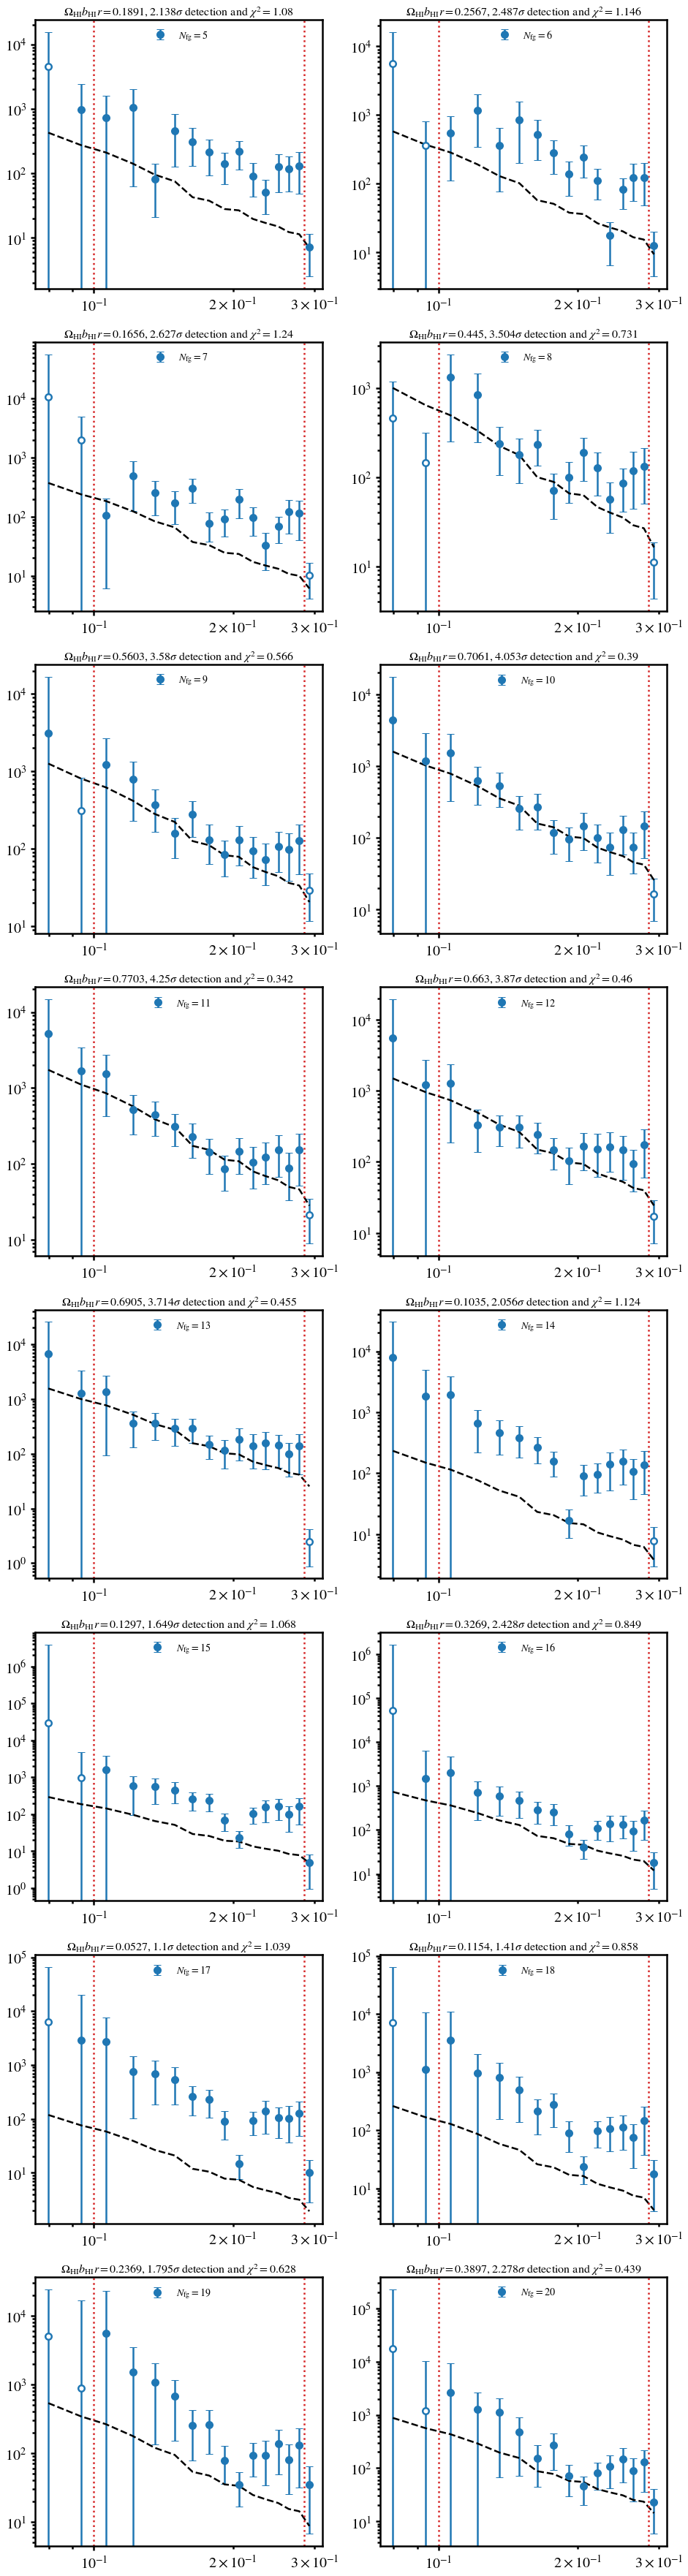

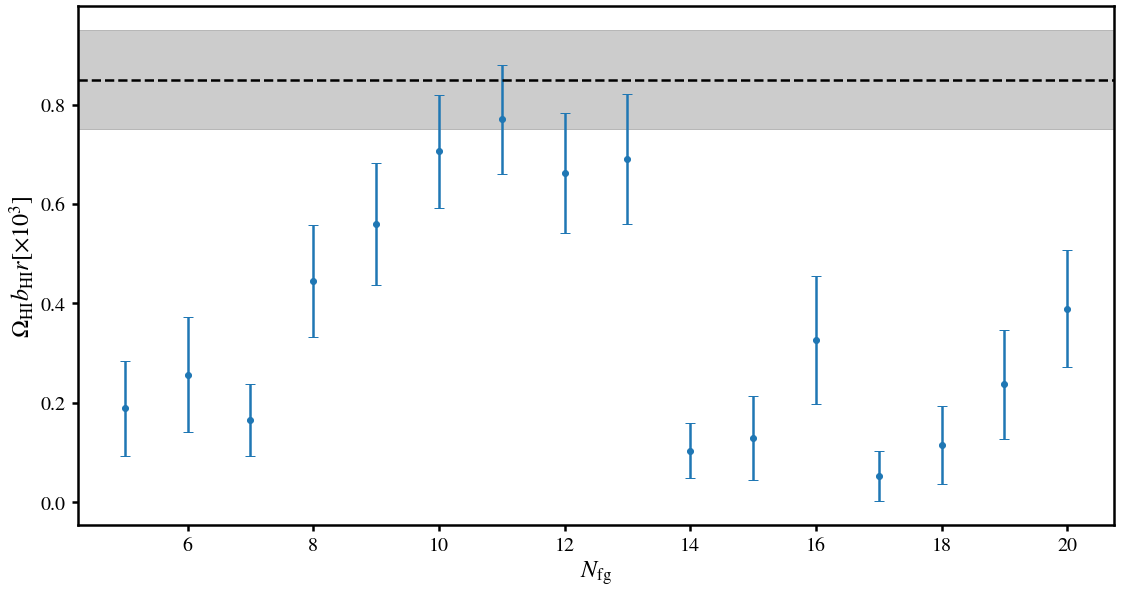

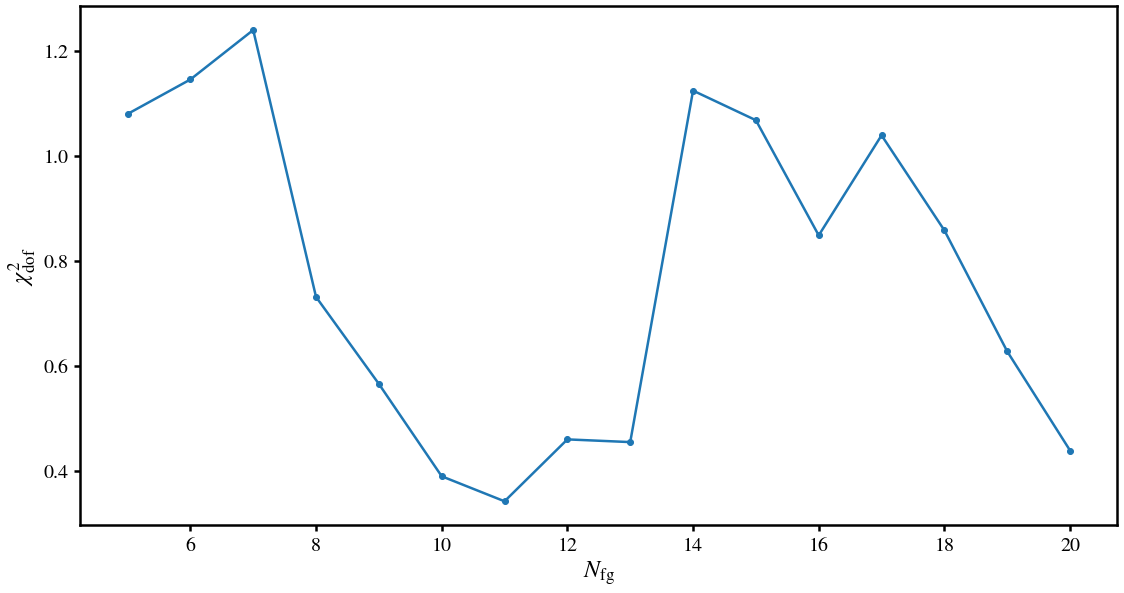

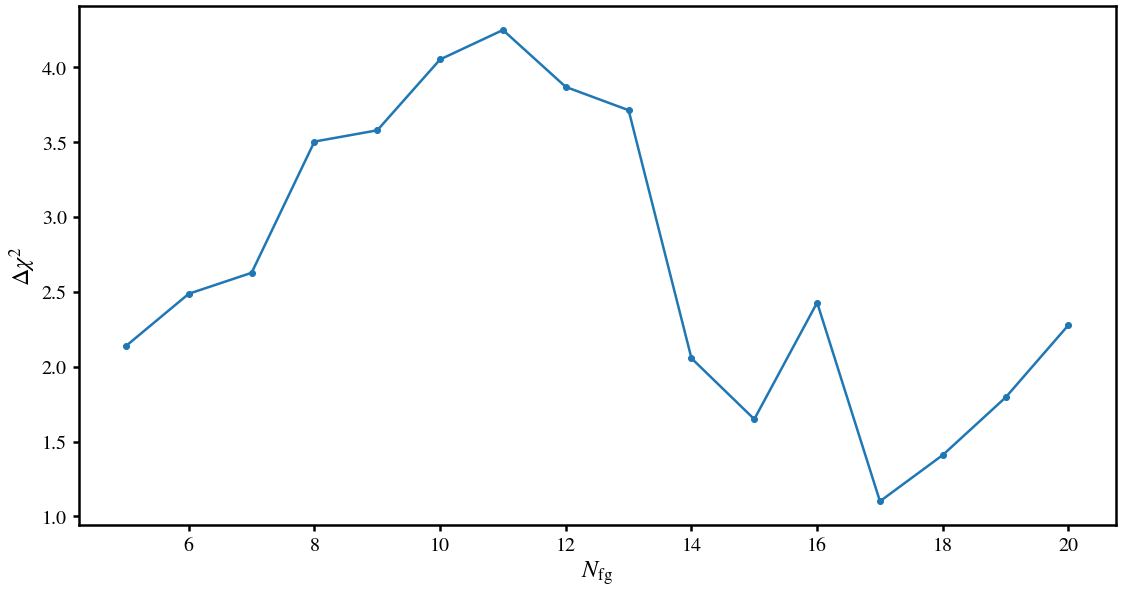

In [17]:
N_fgs = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
print(len(N_fgs))

OmegaHIs,sigOmegaHIs,Chi2s,DetSigs = np.zeros(len(N_fgs)),np.zeros(len(N_fgs)),np.zeros(len(N_fgs)),np.zeros(len(N_fgs))
fig, axs = plt.subplots(int((len(N_fgs)+1)/2),2,figsize=(15,60))
for i in range(len(N_fgs)):
    print('\n----------------------------------------------')
    print(i,N_fgs[i])
    MKmap_clean_i = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean_i,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg_i,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

    # Calculate cross-power specs:
    Pk_gHI_Nfg,k,nmodes = power.Pk(MKmap_clean_rg_i,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)

    #TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s_'%(N_fgs[i],gamma_label)+kcuts_label
    TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s_'%(N_fgs[i],gamma_label)+kcuts_label+'_tukeyHI=%s'%tukey_alpha
    T_wsub_i_Nfg, T_nosub_i_Nfg,k  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fgs[i],'Cross',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                                Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,gal_cat=gal_cat,
                                                gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                                w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,kcuts=kcuts,
                                                taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF)

    T_i_Nfg = np.copy(T_nosub_i_Nfg)
    T_Nfg = np.mean(T_i_Nfg,0)
    deltaT_i_Nfg = T_i_Nfg - T_Nfg
    Pk_rec_Nfg = Pk_gHI_Nfg/T_Nfg
    # Propagate error on TF into error on power:
    deltaPk_i_Nfg =  Pk_rec_Nfg * (deltaT_i_Nfg/T_Nfg) 
    Pk_rec_i_Nfg = Pk_rec_Nfg + deltaPk_i_Nfg # corrected power uncertainty distribution
    # Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
    ### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
    lower_error = np.abs(np.percentile(deltaPk_i_Nfg,15.865,axis=0))
    upper_error = np.abs(np.percentile(deltaPk_i_Nfg,84.135,axis=0))
    asymmetric_error_Nfg = np.array(list(zip(lower_error, upper_error))).T


    # Fit OmegaHI and calculate detection significance and Chi^2:
    if gal_cat=='cmass': kmincut,kmaxcut = 0.09,0.25
    if gal_cat=='gama': kmincut,kmaxcut = 0.1,0.285
    kbin_cut = (k>kmincut) & (k<kmaxcut)


    # Full covariance:      
    OmHIbHIr_fit, sigma_OmHIbHIr = model.LSqFitPkAmplitude(Pk_rec_Nfg,np.cov(Pk_rec_i_Nfg,rowvar=False),Pmod,zeff,dims_rg,kbins,corrtype='Cross',P_N_=0,kmin=kmincut,kmax=kmaxcut,b2=b_g,f=f,sig_v=sig_v,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para)
    OmegaHI_fit = OmHIbHIr_fit/b_HI
    Tbar_fit = HItools.Tbar(zeff,OmegaHI_fit)
    pkmod_fit,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix1=s_pix,s_pix2=0,s_para1=s_para,s_para2=0,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
    print('---- (fitted OmegaHI & diagonal covariance):')
    print('\nOmegaHIbHIr x 10^3 = ',str(np.round(1e3*OmHIbHIr_fit,3)), '+/-', str(np.round(1e3*sigma_OmHIbHIr,3)))
    C = np.cov(Pk_rec_i_Nfg,rowvar=False)
    C = C[kbin_cut]
    C = C[:,kbin_cut]
    chi2 = model.ChiSquare(Pk_rec_Nfg[kbin_cut],pkmod_fit[kbin_cut],C,dof=len(k[kbin_cut]))
    print('\nReduced Chi^2 :' + str(chi2))
    det_sig = model.DetectionSigma(Pk_rec_Nfg[kbin_cut],pkmod_fit[kbin_cut],C)

    OmegaHIs[i],sigOmegaHIs[i] = OmHIbHIr_fit,sigma_OmHIbHIr
    DetSigs[i],Chi2s[i] = det_sig,chi2
    np.save('/idia/projects/hi_im/meerpower/allLband/data/Pkdata_%scross_Nfg=%s_%s'%(gal_cat,N_fgs[i],kcuts_label),[k,Pk_rec_Nfg,asymmetric_error_Nfg,pkmod_fit])
    
    if i%2==0: yi = 0
    else: yi = 1
    axs[int(i/2),yi].errorbar(k,np.abs(Pk_rec_Nfg),asymmetric_error_Nfg,ls='none',marker='o',markersize=10,label=r'$N_{\rm fg}=%s$'%N_fgs[i])
    axs[int(i/2),yi].scatter(k[Pk_rec_Nfg<0],np.abs(Pk_rec_Nfg[Pk_rec_Nfg<0]),marker='o',facecolors='white',color='tab:blue',zorder=10,s=50)
    axs[int(i/2),yi].plot(k,pkmod_fit,ls='--',color='black')
    axs[int(i/2),yi].axvline(kmincut,color='tab:red',ls=':')
    axs[int(i/2),yi].axvline(kmaxcut,color='tab:red',ls=':')
    axs[int(i/2),yi].loglog()
    axs[int(i/2),yi].legend(fontsize=14,frameon=False,loc='upper center')
    axs[int(i/2),yi].set_title(r'$\Omega_{\rm HI}b_{\rm HI}r=%s, %s\sigma$ detection'%(np.round(OmHIbHIr_fit*1e3,4),np.round(det_sig,3)) + ' and $\chi^2=%s$'%np.round(chi2,3),fontsize=16)
plt.show()

plt.errorbar(N_fgs,OmegaHIs*1e3,sigOmegaHIs*1e3,ls='none',marker='o')
plt.axhline(OmegaHIbHI*1e3,color='black',ls='--')
plt.axhspan(OmegaHIbHI*1e3-0.1, OmegaHIbHI*1e3+0.1, color='black', alpha=0.2)
plt.xlabel(r'$N_{\rm fg}$')
plt.ylabel(r'$\Omega_{\rm HI}b_{\rm HI}r [\times 10^3]$')
plt.show()
plt.plot(N_fgs,Chi2s,'-o')
plt.xlabel(r'$N_{\rm fg}$')
plt.ylabel(r'$\chi_{\rm dof}^2$')
plt.show()
plt.plot(N_fgs,DetSigs,'-o')
plt.xlabel(r'$N_{\rm fg}$')
plt.ylabel(r'$\Delta\chi^2$')
plt.show()

--------------------------------------------------------
# Pipeline under development from here and may not work:
--------------------------------------------------------

# Null testing:
Load in mock galaxies in place of real galaxies to test collapsing the correlation with all other things fixed

In [29]:
'''
Nmock = 5
Pk_gHI_null = np.zeros((Nmock,nkbin))
for i in range(Nmock+1):
    plot.ProgressBar(i,Nmock+1)
    if i<Nmock: # load mocks
        if gal_cat=='wigglez': 
            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat_%s.npy'%i)
            z_Lband = (z_g_mock>zmin) & (z_g_mock<zmax) # Cut redshift to MeerKAT IM range:
            ra_g_mock,dec_g_mock,z_g_mock = ra_g_mock[z_Lband],dec_g_mock[z_Lband],z_g_mock[z_Lband]    
        if gal_cat=='cmass':
            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat_%s.npy'%i)
            ra_g_mock,dec_g_mock,z_g_mock = Init.pre_process_2019Lband_CMASS_galaxies(ra_g_mock,dec_g_mock,z_g_mock,ra,dec,zmin,zmax,W_HI)    
        if gal_cat=='gama': 
            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%i)
            # Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
            GAMAcutmask = (ra_g_mock>ramin_gal) & (ra_g_mock<ramax_gal) & (dec_g_mock>decmin_gal) & (dec_g_mock<decmax_gal) & (z_g_mock>zmin) & (z_g_mock<zmax)
            ra_g_mock,dec_g_mock,z_g_mock = ra_g_mock[GAMAcutmask],dec_g_mock[GAMAcutmask],z_g_mock[GAMAcutmask]
        xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_mock,dec_g_mock,z_g_mock,ramean_arr=ra,decmean_arr=dec,doTile=False)
        n_g_rg_mock = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]
        Pk_gHI_null[i],k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg_mock,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)    
        plt.plot(k,k**2*Pk_gHI_null[i],lw=0.08,color='black')
    if i==Nmock: # compute Pk for real data again to overlay as comparison:
        Pk_gHI,k,nmodes = power.Pk(MKmap_clean_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)
        plt.errorbar(k,k**2*Pk_gHI,k**2*sig_err,ls='none',marker='o',zorder=10)
    plt.plot(k,k**2*pkmod,ls='--',color='black')
plt.errorbar(k,k**2*np.mean(Pk_gHI_null,0),k**2*np.std(Pk_gHI_null,0),ls='none',marker='o',color='tab:red')
plt.axhline(0,color='gray',lw=1,ls='--',zorder=-10)
plt.show()
'''

"\nNmock = 5\nPk_gHI_null = np.zeros((Nmock,nkbin))\nfor i in range(Nmock+1):\n    plot.ProgressBar(i,Nmock+1)\n    if i<Nmock: # load mocks\n        if gal_cat=='wigglez': \n            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockWiggleZcat_%s.npy'%i)\n            z_Lband = (z_g_mock>zmin) & (z_g_mock<zmax) # Cut redshift to MeerKAT IM range:\n            ra_g_mock,dec_g_mock,z_g_mock = ra_g_mock[z_Lband],dec_g_mock[z_Lband],z_g_mock[z_Lband]    \n        if gal_cat=='cmass':\n            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2019Lband/mocks/mockCMASScat_%s.npy'%i)\n            ra_g_mock,dec_g_mock,z_g_mock = Init.pre_process_2019Lband_CMASS_galaxies(ra_g_mock,dec_g_mock,z_g_mock,ra,dec,zmin,zmax,W_HI)    \n        if gal_cat=='gama': \n            ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%i)\n            # Remove galaxies outside bulk GAM


OmegaHI b_HI r = 2.2334 +- 0.1602 [x10^-3]

Reduced Chi^2: 1.0999886157150904


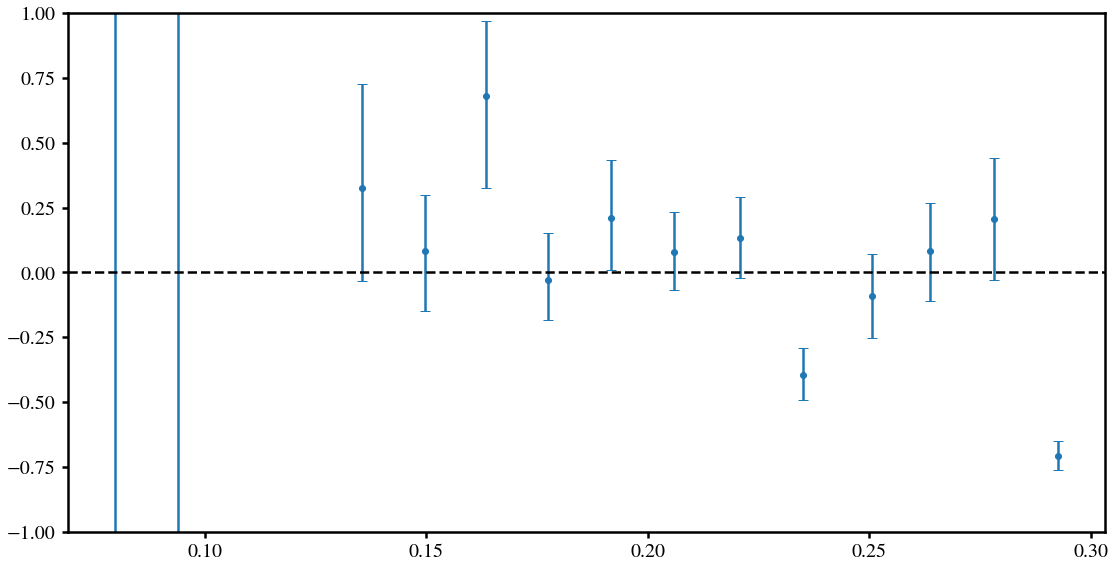

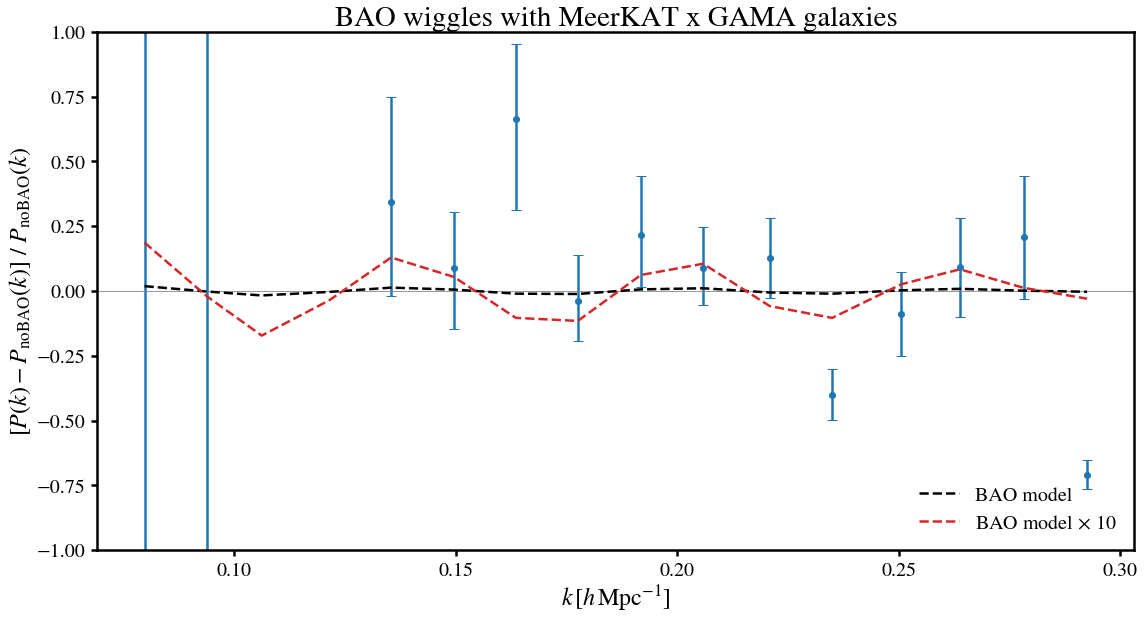

In [17]:
#### BAO testing:
import scipy
def Pk_noBAO(Pk,k,kBAO=[0.03,0.3]):
    """ Code from Ze - following Phil Bull method (https://arxiv.org/pdf/1405.1452.pdf)
    Construct a smooth power spectrum with BAOs removed, and a corresponding
    BAO template function, by using a two-stage splining process."""
    if k[0]>kBAO[0]: print('ERROR! k-range outside BAO scales')
    if k[-1]<kBAO[-1]: print('ERROR! k-range outside BAO scales')
    # Get interpolating function for input P(k) in log-log space
    _interp_pk = scipy.interpolate.interp1d(np.log(k),np.log(Pk),kind='quadratic',bounds_error=False )
    interp_pk = lambda x: np.exp(_interp_pk(np.log(x)))
    # Spline all (log-log) points except those in user-defined "wiggle region",
    # and then get derivatives of result
    idxs = np.where(np.logical_or(k <= kBAO[0], k >= kBAO[1]))
    _pk_smooth = scipy.interpolate.UnivariateSpline(np.log(k[idxs]),np.log(Pk[idxs]),k=3,s=0)
    pk_smooth = lambda x: np.exp(_pk_smooth(np.log(x)))
    # Construct "wiggles" function using spline as a reference, then spline it
    # and find its 2nd derivative
    fwiggle = scipy.interpolate.UnivariateSpline(k,Pk/pk_smooth(k),k=3,s=0)
    derivs = np.array([fwiggle.derivatives(_k) for _k in k]).T
    d2 = scipy.interpolate.UnivariateSpline(k, derivs[2], k=3, s=1)
    # Find maxima and minima of the gradient (zeros of 2nd deriv.), then put a
    # low-order spline through zeros to subtract smooth trend from wiggles fn.
    wzeros = d2.roots()
    wzeros = wzeros[np.where(np.logical_and(wzeros >= kBAO[0], wzeros <= kBAO[1]))]
    wzeros = np.concatenate(([kBAO[0],], wzeros)) # add first k from wiggle range for smooth trend stiching
    wzeros = np.concatenate((wzeros, [kBAO[1],])) # add last k from wiggle range for smooth trend stiching
    wtrend = scipy.interpolate.UnivariateSpline(wzeros, fwiggle(wzeros), k=3, s=0)
    # Construct smooth "no-bao" function by summing the original splined function and
    # the wiggles trend function
    idxs = np.where(np.logical_and(k > kBAO[0], k < kBAO[1]))
    Pk_smooth = pk_smooth(k)
    Pk_smooth[idxs] *= wtrend(k[idxs])
    f_BAO = (Pk - Pk_smooth)/Pk_smooth
    return Pk_smooth,f_BAO

N_fg = 8
MKmap_clean_i = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean_i,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg_i,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
# Calculate auto and cross-power specs:
Pk_gHI,k,nmodes = power.Pk(MKmap_clean_rg_i,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)
TFfile = '/idia/projects/hi_im/meerpower/'+survey+'Lband/'+gal_cat+'/TFdata/T_Nfg=%s_gamma=%s_'%(N_fgs[i],gamma_label)+kcuts_label
T_wsub_i, T_nosub_i,k  = foreground.TransferFunction(MKmap_unsmoothed,Nmock,N_fgs[i],'Cross',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,
                                            Np,window,compensate,interlace,mockfilepath_HI,mockfilepath_g,gal_cat=gal_cat,
                                            gamma=gamma,D_dish=D_dish,w_HI=w_HI,W_HI=W_HI,doWeightFGclean=True,PCAMeanCentre=True,
                                            w_HI_rg=w_HI_rg,W_HI_rg=W_HI_rg,w_g_rg=w_g_rg,W_g_rg=W_g_rg,kcuts=kcuts,
                                            taper_HI=blackman,taper_g=blackman,LoadTF=LoadTF)

T_i = np.copy(T_nosub_i)
T = np.mean(T_i,0)
deltaT_i = T_i - T
Pk_rec = Pk_gHI/T
# Propagate error on TF into error on power:
deltaPk_i =  Pk_rec * (deltaT_i/T) 
Pk_rec_i = Pk_rec + deltaPk_i # corrected power uncertainty distribution
# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(deltaPk_i,15.865,axis=0))
upper_error = np.abs(np.percentile(deltaPk_i,84.135,axis=0))
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

asymmetric_error /= 3.5

kmincut,kmaxcut = 0.125,0.22
kbin_cut = (k>kmincut) & (k<kmaxcut)
OmHIbHIr_fit, sigma_OmHIbHIr = model.LSqFitPkAmplitude(Pk_rec,np.mean(asymmetric_error,0),Pmod,zeff,dims_rg,kbins,corrtype='Cross',P_N_=0,kmin=kmincut,kmax=kmaxcut,b2=b_g,f=f,sig_v=sig_v,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para)
OmegaHIs[i],sigOmegaHIs[i] = OmHIbHIr_fit,sigma_OmHIbHIr
print('\nOmegaHI b_HI r = ' + str(np.round(OmHIbHIr_fit*1e3,4)) + ' +- ' + str(np.round(sigma_OmHIbHIr*1e3,4)) + ' [x10^-3]' )
OmegaHI_fit = OmHIbHIr_fit/b_HI
Tbar_fit = HItools.Tbar(zeff,OmegaHI_fit)
pkmod_fit,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
print('\nReduced Chi^2: ' + str(model.ChiSquare(Pk_rec[kbin_cut],pkmod_fit[kbin_cut],np.mean(asymmetric_error,0)[kbin_cut],dof=len(k[kbin_cut]))))

kmod = np.linspace(0.001,3,500)
Pk_smooth,f_BAO = Pk_noBAO(Pmod(kmod),kmod)
from scipy.interpolate import interp1d
Pmod_smooth = interp1d(kmod,Pk_smooth,kind='cubic')
pkmod_wBAO,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]
pkmod_noBAO,k = model.PkMod(Pmod_smooth,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar_fit,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)[0:2]

plt.axhline(0,color='gray',lw=0.8)
plt.plot(k,(pkmod_wBAO - pkmod_noBAO)/pkmod_noBAO,color='black',ls='--',label='BAO model')
plt.plot(k,10*(pkmod_wBAO - pkmod_noBAO)/pkmod_noBAO,color='tab:red',ls='--',label=r'BAO model $\times$ 10')
plt.errorbar(k,(Pk_rec - pkmod_noBAO)/pkmod_noBAO, asymmetric_error/pkmod_noBAO, ls='none',marker='o')
plt.ylim(-1,1)
plt.legend(fontsize = 20,frameon=False,loc='lower right')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$[P(k) - P_{\rm noBAO}(k)]\,\,/\,\,P_{\rm noBAO}(k)$')
plt.title('BAO wiggles with MeerKAT x GAMA galaxies')
plt.show()


Performing loop:
[====                          ] 14%Internal Python error in the inspect module.
Below is the traceback from this internal error.




KeyboardInterrupt



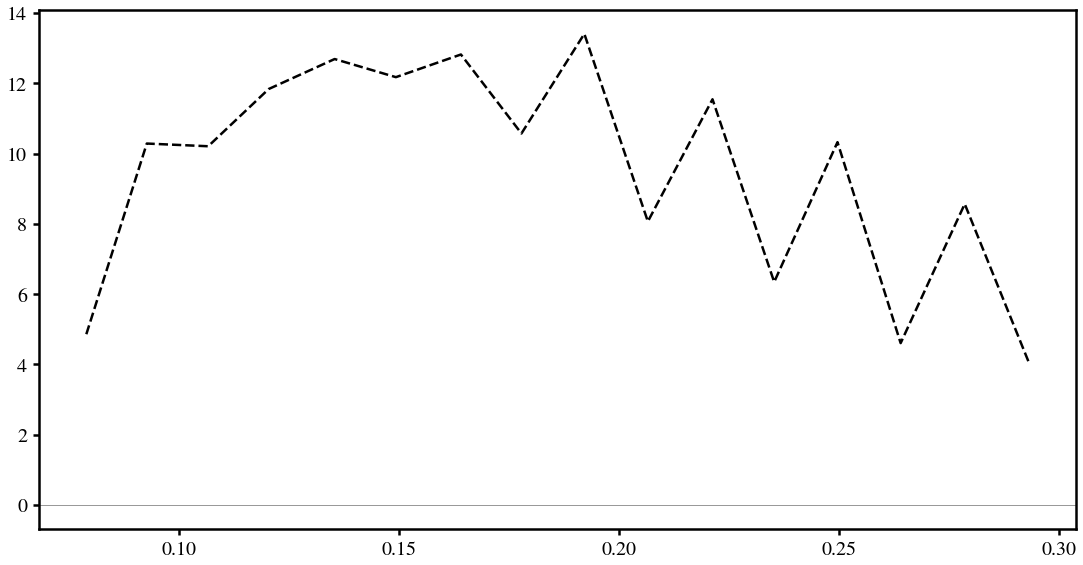

In [18]:
### Multipole expansion testing:
N_fg = 8
MKmap_clean_i = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean_i,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg_i,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
# Calculate auto and cross-power specs:
pk0,pk2,pk4,k,nmodes = power.Pk(MKmap_clean_rg_i,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,doMultipole=True)
pk0mod,pk2mod,pk4mod,k,nmodes = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam_gam,R_beam2=0,w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,doMultipole=True,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=True,gridinterp=True)

plt.axhline(0,lw=0.8,color='gray')
plt.plot(k,k**2*pk2mod,ls='--',color='black',label='Model')
#'''
Nmock = 50
Pk0_mock,Pk2_mock,Pk4_mock = np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin))
Pk0_mock_noRSD,Pk2_mock_noRSD,Pk4_mock_noRSD = np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin))
for i in range(Nmock):
    plot.ProgressBar(i,Nmock)

    # With RSD mocks:
    dT_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%i)
    if gamma is not None: dT_mock_wFGs = telescope.weighted_reconvolve(dT_mock + MKmap_unsmoothed,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)[0]
    if gamma is None: dT_mock_wFGs = dT_mock + MKmap_unsmoothed
    dT_mock_wFGs[W_HI==0] = 0 # ensure same pixels are flagged
    dT_mock_clean = foreground.PCAclean(dT_mock_wFGs,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=dT_mock_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    dT_mock_clean_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%i)
    # Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
    GAMAcutmask = (ra_g_mock>ramin_gal) & (ra_g_mock<ramax_gal) & (dec_g_mock>decmin_gal) & (dec_g_mock<decmax_gal) & (z_g_mock>zmin) & (z_g_mock<zmax)
    ra_g_mock,dec_g_mock,z_g_mock = ra_g_mock[GAMAcutmask],dec_g_mock[GAMAcutmask],z_g_mock[GAMAcutmask]
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_mock,dec_g_mock,z_g_mock,ramean_arr=ra,decmean_arr=dec,doTile=False)
    n_g_rg_mock = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]
    Pk0_mock[i],Pk2_mock[i],Pk4_mock[i],k,nmodes = power.Pk(dT_mock_clean_rg , n_g_rg_mock , dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,doMultipole=True)

    # No RSD mocks:
    dT_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s_noRSD.npy'%i)
    if gamma is not None: dT_mock_wFGs = telescope.weighted_reconvolve(dT_mock + MKmap_unsmoothed,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)[0]
    if gamma is None: dT_mock_wFGs = dT_mock + MKmap_unsmoothed
    dT_mock_wFGs[W_HI==0] = 0 # ensure same pixels are flagged
    dT_mock_clean = foreground.PCAclean(dT_mock_wFGs,N_fg=N_fg,W=W_HI,w=w_HI,MeanCentre=True) # weights included in covariance calculation
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=dT_mock_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    dT_mock_clean_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s_noRSD.npy'%i)
    # Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
    GAMAcutmask = (ra_g_mock>ramin_gal) & (ra_g_mock<ramax_gal) & (dec_g_mock>decmin_gal) & (dec_g_mock<decmax_gal) & (z_g_mock>zmin) & (z_g_mock<zmax)
    ra_g_mock,dec_g_mock,z_g_mock = ra_g_mock[GAMAcutmask],dec_g_mock[GAMAcutmask],z_g_mock[GAMAcutmask]
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_g_mock,dec_g_mock,z_g_mock,ramean_arr=ra,decmean_arr=dec,doTile=False)
    n_g_rg_mock = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]
    Pk0_mock_noRSD[i],Pk2_mock_noRSD[i],Pk4_mock_noRSD[i],k,nmodes = power.Pk(dT_mock_clean_rg , n_g_rg_mock , dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=w_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts,doMultipole=True)
    
    
    #plt.plot(k,k**2*Pk2_mock[i],lw=0.4,color='black')
    #plt.plot(k,k**2*Pk2_mock_noRSD[i],lw=0.4,color='tab:red')
#'''
plt.errorbar(k,k**2*pk2,k**2*np.std(Pk2_mock,0),ls='none',marker='o',label=r'MK$\times$GAMA',markersize=10)
plt.errorbar(k+0.001,k**2*np.mean(Pk2_mock,0),k**2*np.std(Pk2_mock,0),color='tab:green',ls='none',marker='o',label='Mocks with RSD')
plt.errorbar(k+0.002,k**2*np.mean(Pk2_mock_noRSD,0),k**2*np.std(Pk2_mock_noRSD,0),color='tab:red',ls='none',marker='o',label='Mocks without RSD')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k^2\,P_2(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.title('Quadrupole with MeerKAT x GAMA (no signal loss correction)')
plt.legend(frameon=True,fontsize=14)
plt.show()
 